### Importing the required libraries:

In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
#from sklearn.preprocessing import OrdinalEncoder
#from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.utils import resample
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import Pool
import optuna
#from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import KFold

from warnings import filterwarnings
from sklearn.utils import resample
from optuna.samplers import TPESampler
import multiprocessing
filterwarnings("ignore", category=DeprecationWarning) 
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

#pip install --quiet shap==0.39.0
import shap

C:\Users\deepn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Loading the Data

In [7]:
df_data = pd.read_csv("../Dataset/train_dataset.csv")
df_data.head()

Year_Factor State_Factor building_class  \
0            1      State_1     Commercial   
1            1      State_1     Commercial   
2            1      State_1     Commercial   
3            1      State_1     Commercial   
4            1      State_1     Commercial   

                               facility_type  floor_area  year_built  \
0               Grocery_store_or_food_market     61242.0      1942.0   
1  Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                       Retail_Enclosed_mall    280025.0      1951.0   
3                  Education_Other_classroom     55325.0      1980.0   
4                  Warehouse_Nonrefrigerated     66000.0      1985.0   

   energy_star_rating  ELEVATION  january_min_temp  january_avg_temp  ...  \
0                11.0        2.4                36              50.5  ...   
1                45.0        1.8                36              50.5  ...   
2                97.0        1.8                36              50.5  ...   
3                46.0        1.8                36              50.5  ...   
4               100.0        2.4                36              50.5  ...   

   days_above_80F  days_above_90F  days_above_100F  days_above_110F  \
0              14               0                0                0   
1              14               0                0                0   
2              14               0                0                0   
3              14               0                0                0   
4              14               0                0                0   

   direction_max_wind_speed  direction_peak_wind_speed  max_wind_speed  \
0                       1.0                        1.0             1.0   
1                       1.0                        NaN             1.0   
2                       1.0                        NaN             1.0   
3                       1.0                        NaN             1.0   
4                       1.0                        1.0             1.0   

   days_with_fog    site_eui  id  
0            NaN  248.682615   0  
1           12.0   26.500150   1  
2           12.0   24.693619   2  
3           12.0   48.406926   3  
4            NaN    3.899395   4  

[5 rows x 64 columns]

In [3]:
x_test = pd.read_csv("../Dataset/x_test.csv")

y_test = pd.read_csv("../Dataset/y_test.csv")

In [5]:
def print_null(df):
    for col in df.columns:
        if(df[col].isnull().sum()!=0):
            print(col,' => ',df[col].isnull().sum())

print_null(x_test)

year_built  =>  92
energy_star_rating  =>  2254
direction_max_wind_speed  =>  8575
direction_peak_wind_speed  =>  8575
max_wind_speed  =>  8575
days_with_fog  =>  9117


>X_test also needs to be pre-processed separately to avoid leakage

In [6]:
print_null(y_test)

### Exploratory Data Analysis

In [8]:
temp_df=df_data.copy()

In [9]:
temp_df=temp_df.drop_duplicates()

In [10]:
temp_df.shape

(75757, 64)

In [11]:
temp_df.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

In [12]:
temp_df.columns = temp_df.columns.str.lower()
print(temp_df.columns)

Index(['year_factor', 'state_factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'elevation',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

In [13]:
temp_df.describe()


year_factor    floor_area    year_built  energy_star_rating  \
count  75757.000000  7.575700e+04  73920.000000        49048.000000   
mean       4.367755  1.659839e+05   1952.306764           61.048605   
std        1.471441  2.468758e+05     37.053619           28.663683   
min        1.000000  9.430000e+02      0.000000            0.000000   
25%        3.000000  6.237900e+04   1927.000000           40.000000   
50%        5.000000  9.136700e+04   1951.000000           67.000000   
75%        6.000000  1.660000e+05   1977.000000           85.000000   
max        6.000000  6.385382e+06   2015.000000          100.000000   

          elevation  january_min_temp  january_avg_temp  january_max_temp  \
count  75757.000000      75757.000000      75757.000000      75757.000000   
mean      39.506323         11.432343         34.310468         59.054952   
std       60.656596          9.381027          6.996108          5.355458   
min       -6.400000        -19.000000         10.806452         42.000000   
25%       11.900000          6.000000         29.827586         56.000000   
50%       25.000000         11.000000         34.451613         59.000000   
75%       42.700000         13.000000         37.322581         62.000000   
max     1924.500000         49.000000         64.758065         91.000000   

       february_min_temp  february_avg_temp  ...  days_above_80f  \
count       75757.000000       75757.000000  ...    75757.000000   
mean           11.720567          35.526837  ...       82.709809   
std            12.577272           8.866697  ...       25.282913   
min           -13.000000          13.250000  ...        0.000000   
25%             2.000000          31.625000  ...       72.000000   
50%             9.000000          34.107143  ...       84.000000   
75%            20.000000          40.879310  ...       97.000000   
max            48.000000          65.107143  ...      260.000000   

       days_above_90f  days_above_100f  days_above_110f  \
count    75757.000000     75757.000000     75757.000000   
mean        14.058701         0.279539         0.002442   
std         10.943996         2.252323         0.142140   
min          0.000000         0.000000         0.000000   
25%          6.000000         0.000000         0.000000   
50%         12.000000         0.000000         0.000000   
75%         17.000000         0.000000         0.000000   
max        185.000000       119.000000        16.000000   

       direction_max_wind_speed  direction_peak_wind_speed  max_wind_speed  \
count              34675.000000               33946.000000    34675.000000   
mean                  66.552675                  62.779974        4.190601   
std                  131.147834                 130.308106        6.458789   
min                    1.000000                   1.000000        1.000000   
25%                    1.000000                   1.000000        1.000000   
50%                    1.000000                   1.000000        1.000000   
75%                    1.000000                   1.000000        1.000000   
max                  360.000000                 360.000000       23.300000   

       days_with_fog      site_eui            id  
count   29961.000000  75757.000000  75757.000000  
mean      109.142051     82.584693  37878.000000  
std        50.699751     58.255403  21869.306509  
min        12.000000      1.001169      0.000000  
25%        88.000000     54.528601  18939.000000  
50%       104.000000     75.293716  37878.000000  
75%       131.000000     97.277534  56817.000000  
max       311.000000    997.866120  75756.000000  

[8 rows x 61 columns]

In [14]:
temp_df['id'].nunique()

75757

> Ids are same as index numbers so its fine to delete the ids

In [15]:
temp_df.drop(['id'],axis=1,inplace=True)
x_test.drop(['id'],axis=1,inplace=True)

In [16]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75757 entries, 0 to 75756
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year_factor                75757 non-null  int64  
 1   state_factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   elevation                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [17]:
cols=temp_df.columns
for col in cols:
  print(col, '=>', temp_df[col].unique())

year_factor => [1 2 3 4 5 6]
state_factor => ['State_1' 'State_2' 'State_4' 'State_6' 'State_8' 'State_10' 'State_11']
building_class => ['Commercial' 'Residential']
facility_type => ['Grocery_store_or_food_market'
 'Warehouse_Distribution_or_Shipping_center' 'Retail_Enclosed_mall'
 'Education_Other_classroom' 'Warehouse_Nonrefrigerated'
 'Warehouse_Selfstorage' 'Office_Uncategorized' 'Data_Center'
 'Commercial_Other' 'Mixed_Use_Predominantly_Commercial'
 'Office_Medical_non_diagnostic' 'Education_College_or_university'
 'Industrial' 'Laboratory' 'Public_Assembly_Entertainment_culture'
 'Retail_Vehicle_dealership_showroom' 'Retail_Uncategorized'
 'Lodging_Hotel' 'Retail_Strip_shopping_mall' 'Education_Uncategorized'
 'Health_Care_Inpatient' 'Public_Assembly_Drama_theater'
 'Public_Assembly_Social_meeting' 'Religious_worship'
 'Mixed_Use_Commercial_and_Residential' 'Office_Bank_or_other_financial'
 'Parking_Garage' 'Commercial_Unknown'
 'Service_Vehicle_service_repair_shop' 'Service_Dry

In [18]:
print_null(temp_df)

year_built  =>  1837
energy_star_rating  =>  26709
direction_max_wind_speed  =>  41082
direction_peak_wind_speed  =>  41811
max_wind_speed  =>  41082
days_with_fog  =>  45796


> *days_with_fog* has more than half of the null values. But it cant be removed as CO2 emission leads to decrease in fog. And its highly correlated.

<AxesSubplot:>

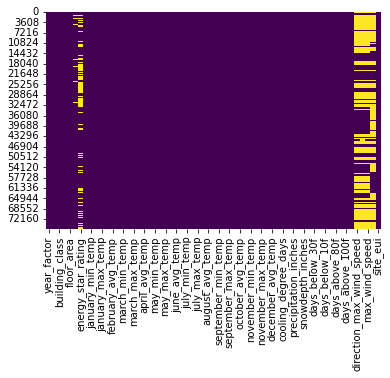

In [19]:
sns.heatmap(temp_df.isnull(),cbar=False,cmap='viridis')

<AxesSubplot:>

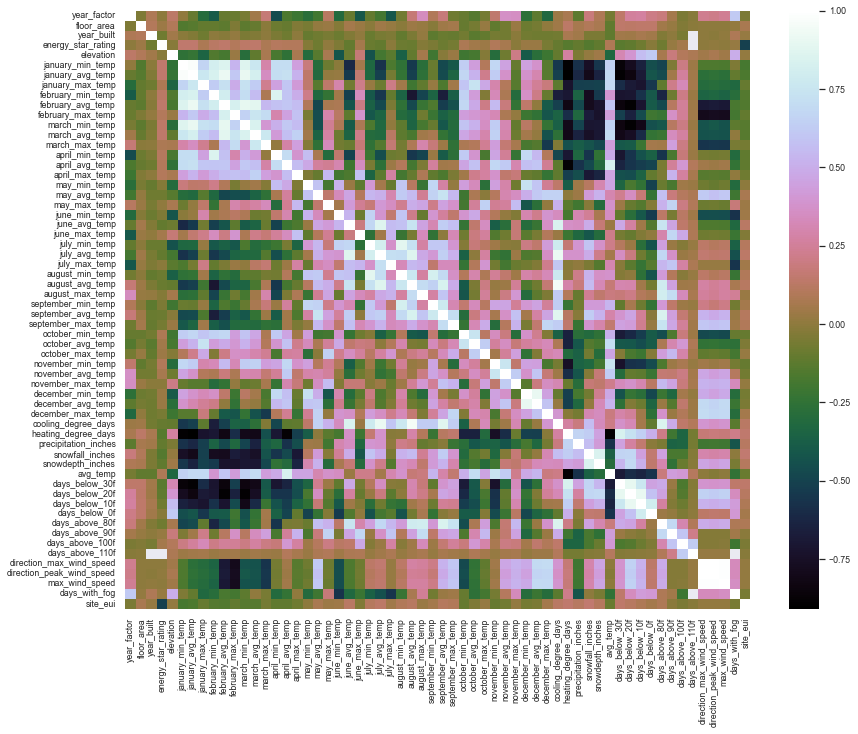

In [20]:
data = temp_df[~temp_df.isnull()].copy()
plt.figure(figsize=(14,11))
sns.set(font_scale=0.8)
sns.heatmap(data.corr(), annot=False, cmap = 'cubehelix')

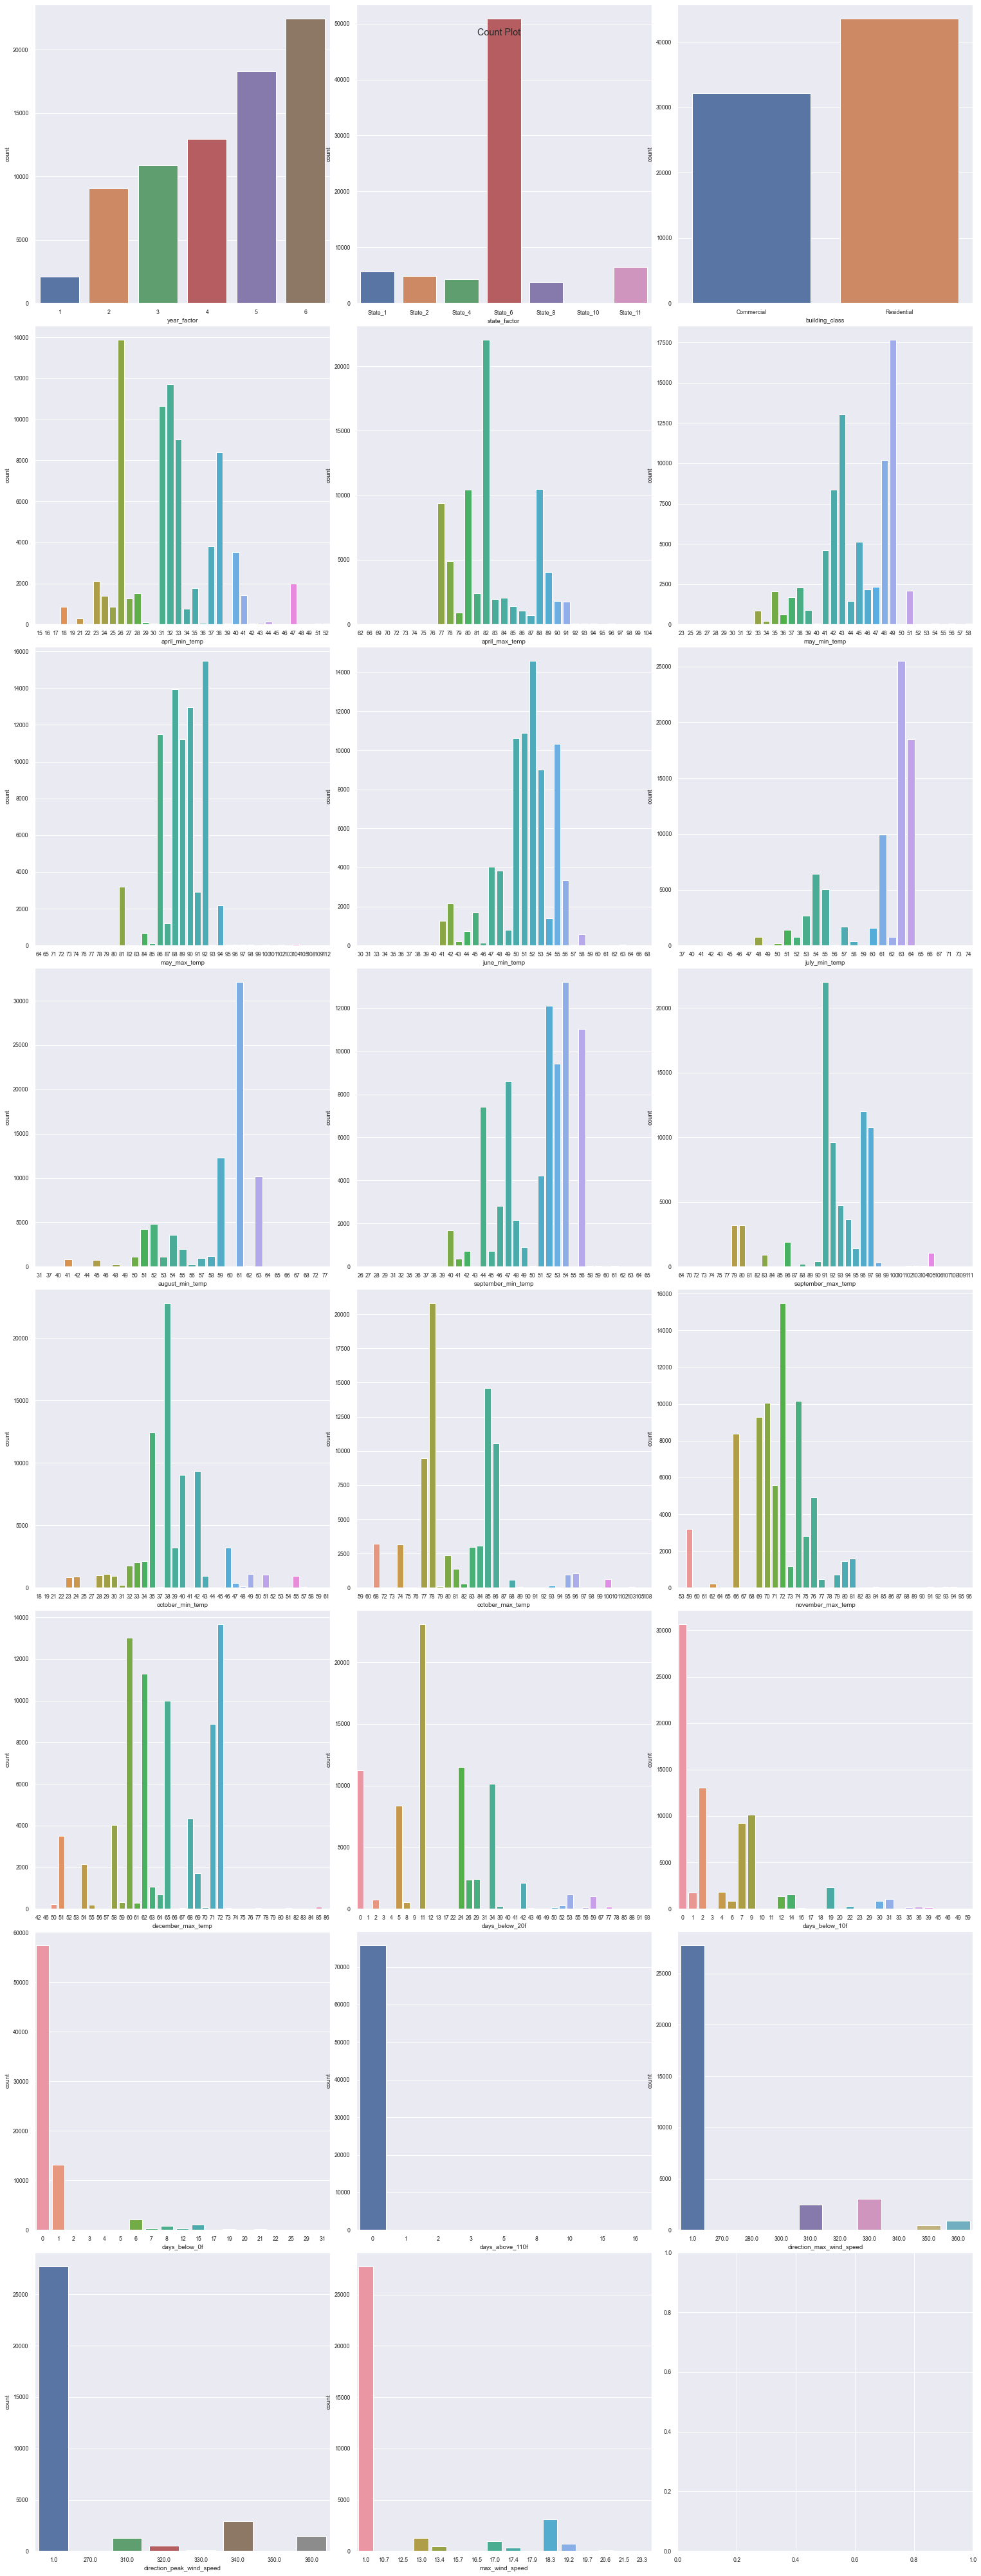

In [30]:
#fig, ax = plt.subplots(24,3,figsize=(20,60))
fig, axs = plt.subplots(nrows=8, ncols=3,figsize=(21,56))
sns.set(font_scale=1)
i=0
plt.suptitle("Count Plot")
fig.tight_layout()
for column in cols:
    if data[column].nunique()<40:
        sns.countplot(x=column,data=data,ax=axs[i//3,i%3])
        i=i+1
plt.show()


> ###  Observations
> * Site count increases with the _year_factor_ 
> * _state_factor_ 6, _building_class_ Residential has a highest count
> * Mostly no days for _days_above_110F_ 
> * _may_min_temp_ and _june_min_temp_ count increases with temperature
>


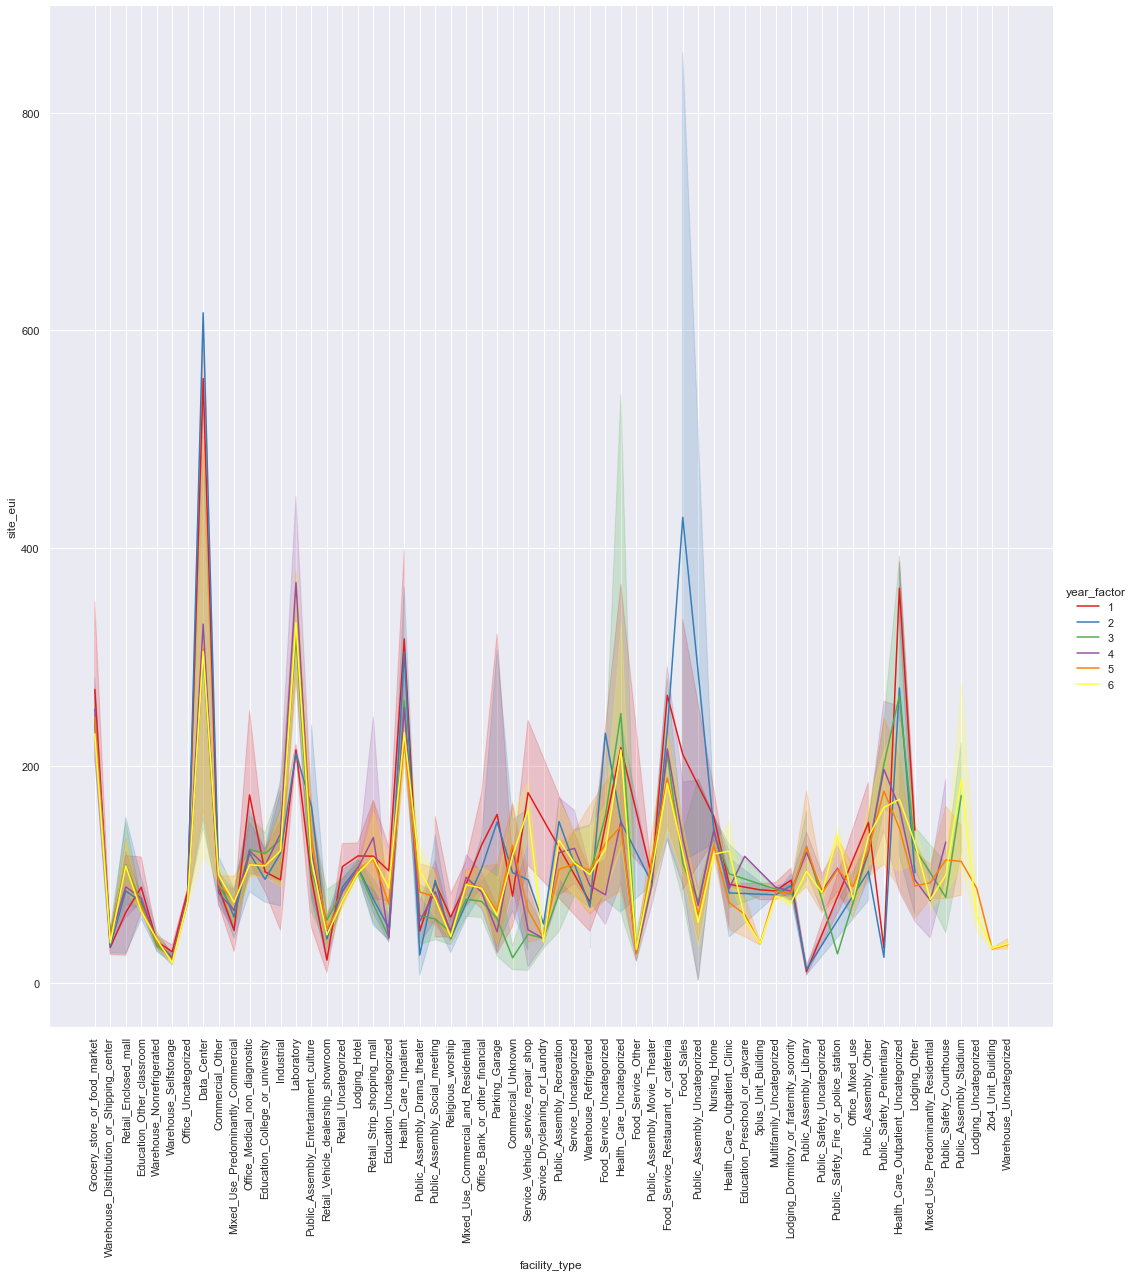

In [31]:
#plt.figure(figsize=(100,100))
sns.set(font_scale=1)
chart = sns.relplot(data=data, x="facility_type", y="site_eui", hue="year_factor",kind="line", legend="full",height=15, palette='Set1')
chart.set_xticklabels( rotation=90)
#plt.show()

In [32]:
facility_impact = data.groupby('facility_type')['site_eui'].mean()
fp = facility_impact.sort_values()

 * Storing the labels in the ordered form to preserve their impact

In [33]:
fp = fp.keys()
fp

Index(['Warehouse_Selfstorage', 'Food_Service_Other', '2to4_Unit_Building',
       'Warehouse_Uncategorized', '5plus_Unit_Building',
       'Warehouse_Nonrefrigerated',
       'Warehouse_Distribution_or_Shipping_center',
       'Service_Drycleaning_or_Laundry', 'Religious_worship',
       'Education_Uncategorized', 'Retail_Vehicle_dealership_showroom',
       'Education_Preschool_or_daycare', 'Public_Assembly_Uncategorized',
       'Lodging_Uncategorized', 'Parking_Garage',
       'Mixed_Use_Predominantly_Commercial', 'Education_Other_classroom',
       'Office_Uncategorized', 'Public_Assembly_Social_meeting',
       'Retail_Uncategorized', 'Public_Assembly_Drama_theater',
       'Lodging_Dormitory_or_fraternity_sorority',
       'Mixed_Use_Predominantly_Residential', 'Office_Mixed_use',
       'Public_Safety_Uncategorized', 'Multifamily_Uncategorized',
       'Mixed_Use_Commercial_and_Residential',
       'Office_Bank_or_other_financial', 'Commercial_Other',
       'Warehouse_Refriger

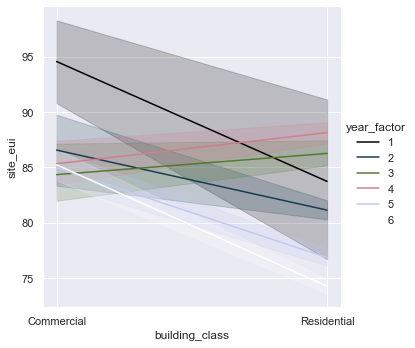

In [34]:
#sns.set(font_scale=1)
sns.relplot(data=data, x="building_class", y="site_eui", hue="year_factor",kind="line", height= 5, palette='cubehelix')
#chart.set_xticklabels( rotation=90)

<AxesSubplot:xlabel='days_with_fog', ylabel='site_eui'>

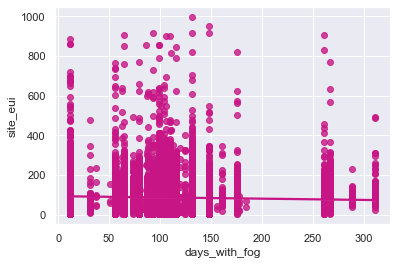

In [35]:
sns.regplot(x="days_with_fog", y="site_eui", data=data, fit_reg=True, color='mediumvioletred')

> _days_with_fog_ has no direct relation with site_eui

fig = plt.figure(figsize=(20,16))
fig.suptitle("Seasonal data")
for i,col in enumerate(season_cols):
    plt.subplot(2, 3, i+1)
    plt.title(col)
    sns.lineplot(data = data, x=col,y='site_eui', color='forestgreen')
    #sns.relplot(x=col, y="site_eui", hue=None, data=data);
plt.show()

* Observations for site-specific features

#site_cols=['year_factor', 'state_factor', 'building_class', 'floor_area', 'year_built', 'energy_star_rating', 'elevation']
site_cols=['year_factor', 'state_factor', 'building_class']

sns.color_palette("hls", 8)

fig = plt.figure(figsize=(16,24))
fig.suptitle("Site-specific Plots")
for i in range(0,3):
    plt.subplot(3, 2, 2*i+1)
    plt.title(site_cols[i])
    sns.displot(data, x=site_cols[i], shrink=.8)
    plt.subplot(3, 2, 2*i + 2)
    sns.displot(data, x="site_eui", hue=site_cols[i]);
    
plt.show()


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x000001D25EA953F0>
Traceback (most recent call last):
  File "C:\Users\deepn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\transforms.py", line 222, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 


<Figure size 1152x2304 with 0 Axes>

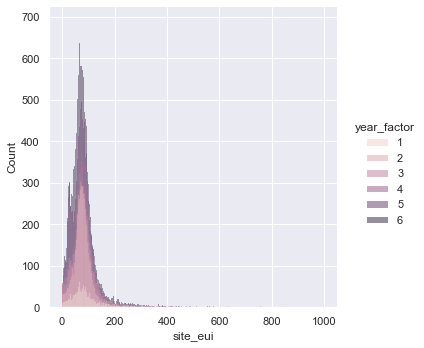

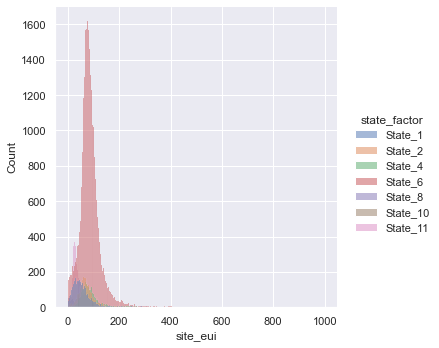

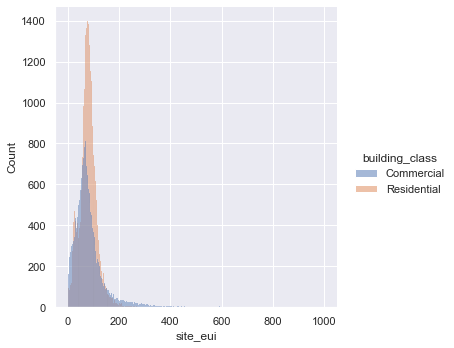

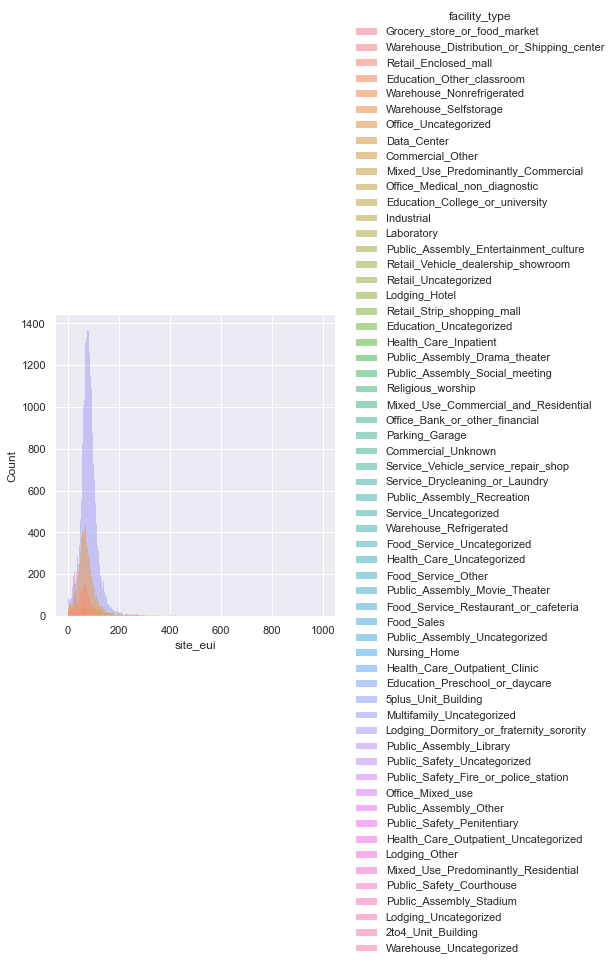

In [62]:
site_cols=['year_factor', 'state_factor','facility_type', 'floor_area', 
'year_built', 'energy_star_rating', 'elevation']
sns.color_palette("hls", 8)
fig = plt.figure(figsize=(16,32))
fig.suptitle("Site-specific Plots")
for i in range(0,4):
    sns.displot(data, x="site_eui", hue=site_cols[i]);
plt.show()

> * **state_factor** - State_6 in state_factor has a high count and also more co2 emission
> * **building_class** - Eventhough no. of residential buildings are more, most of the emission is due to commercial sites.

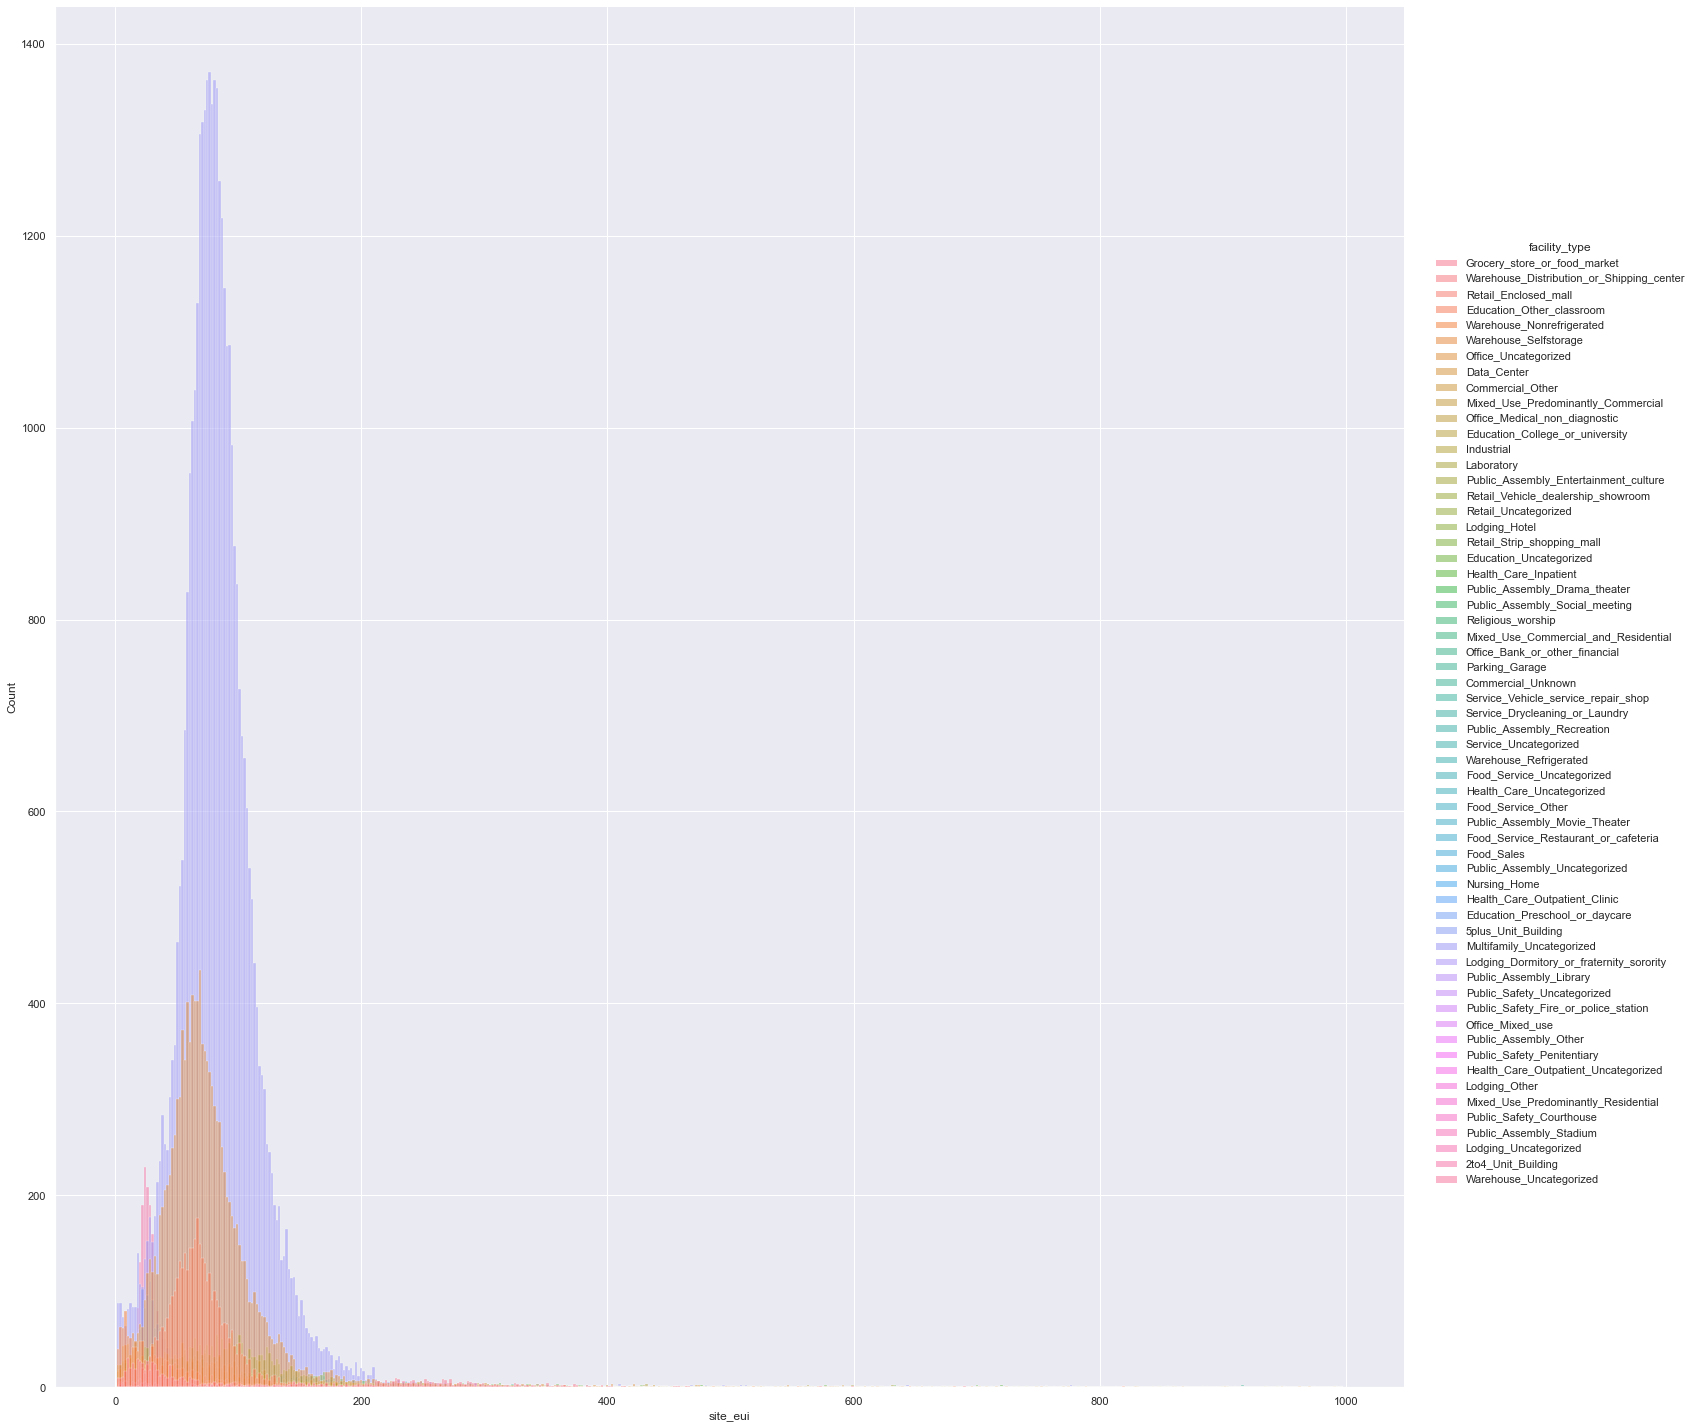

In [63]:
##fig, ax = plt.subplots(figsize=(20,20))
sns.displot(data, x="site_eui", hue='facility_type', height=20, aspect=1);
#plt.show()

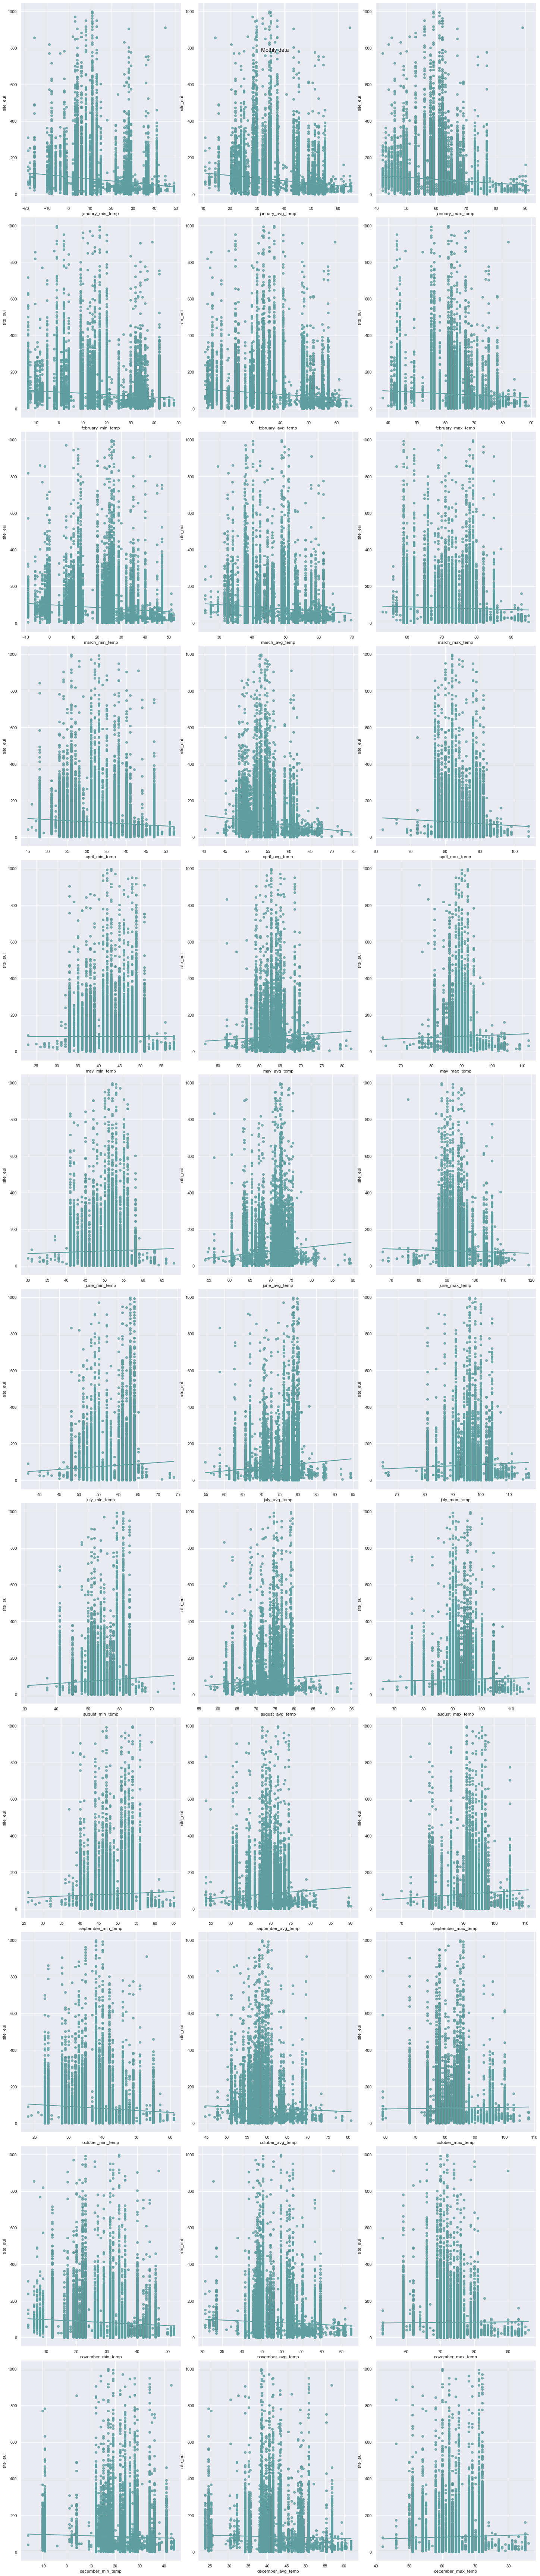

In [64]:
month_cols = ['january_min_temp', 'january_avg_temp', 'january_max_temp', 'february_min_temp', 'february_avg_temp',
    'february_max_temp', 'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp', 'april_avg_temp', 
    'april_max_temp', 'may_min_temp', 'may_avg_temp', 'may_max_temp', 'june_min_temp', 'june_avg_temp', 
    'june_max_temp', 'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp', 'august_avg_temp', 
    'august_max_temp', 'september_min_temp', 'september_avg_temp', 'september_max_temp', 'october_min_temp',
    'october_avg_temp', 'october_max_temp', 'november_min_temp', 'november_avg_temp', 'november_max_temp', 
    'december_min_temp', 'december_avg_temp', 'december_max_temp']
fig, ax = plt.subplots(12,3,figsize=(20,96))
fig.tight_layout()
fig.suptitle("Mothly data")
for i,col in enumerate(month_cols):
    sns.regplot(x=col, y="site_eui",color='cadetblue', data=data, ax=ax[i//3, i%3]);

<AxesSubplot:>

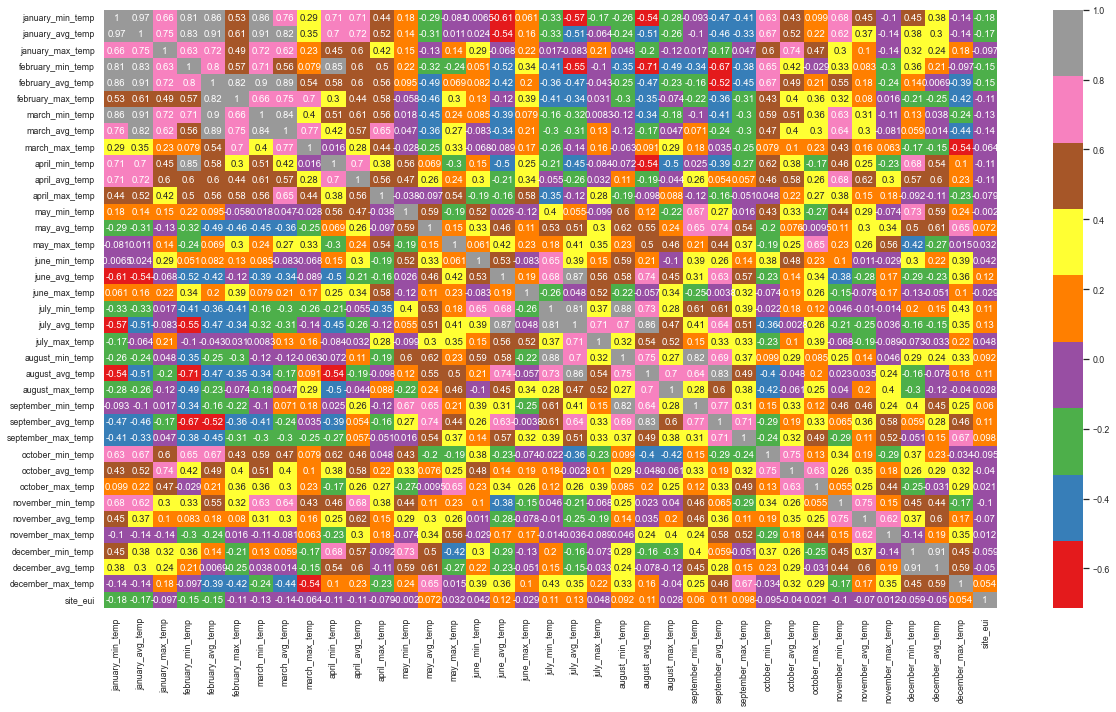

In [65]:
month_cols.append('site_eui')
plt.figure(figsize=(20,11))
sns.set(font_scale=0.8)
sns.heatmap(data[month_cols].corr(), annot=True, cmap = 'Set1')


> * _june_avg_temp_, _july_min_temp_, _july_avg_temp_, _august_avg_temp_, _september_avg_temp_ has higher correlation with site_eui

* Seasonal Features

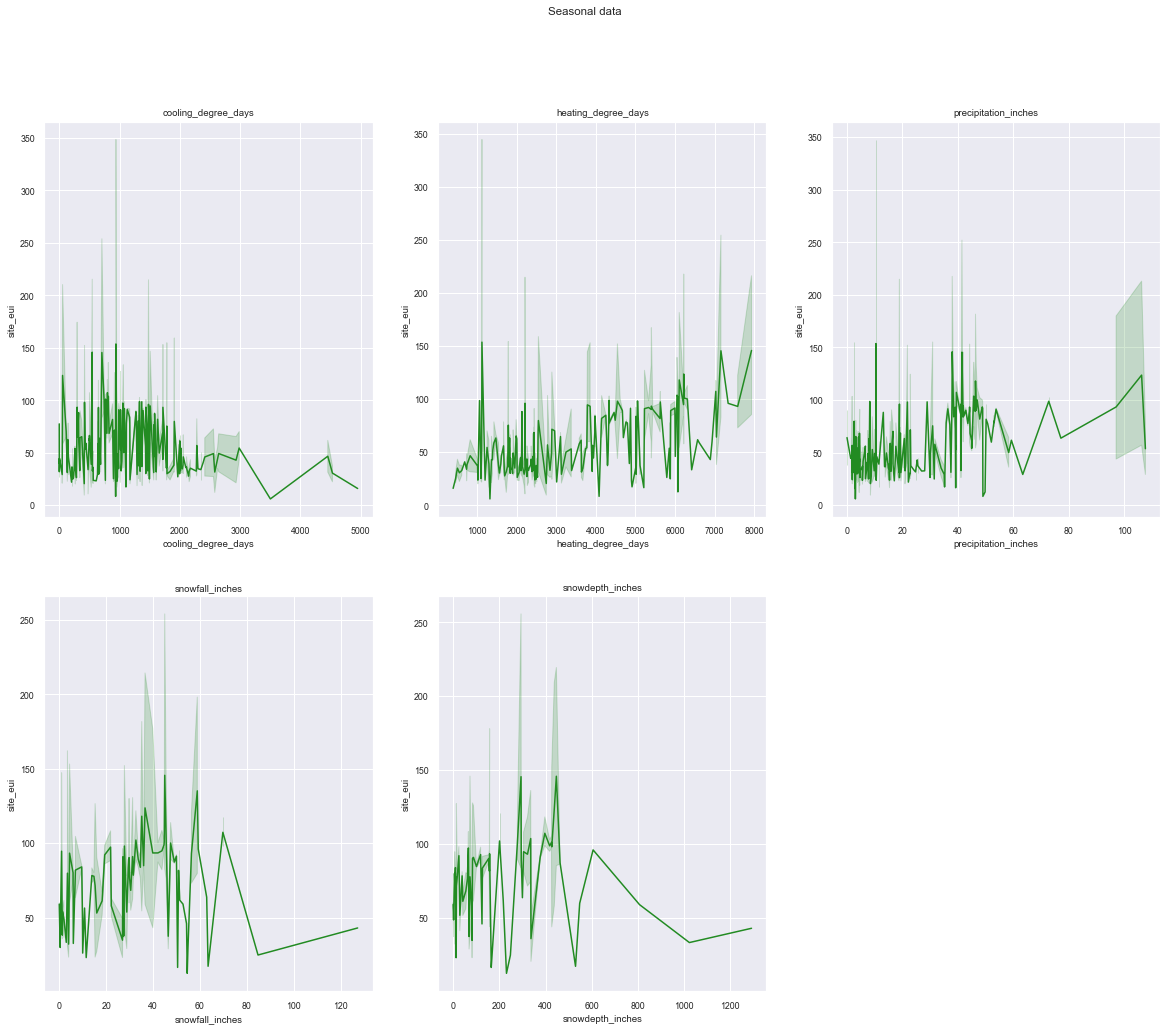

In [66]:
season_cols =['cooling_degree_days', 'heating_degree_days', 'precipitation_inches', 'snowfall_inches','snowdepth_inches']

fig = plt.figure(figsize=(20,16))
fig.suptitle("Seasonal data")
for i,col in enumerate(season_cols):
    plt.subplot(2, 3, i+1)
    plt.title(col)
    sns.lineplot(data = data, x=col,y='site_eui', color='forestgreen')
    #sns.relplot(x=col, y="site_eui", hue=None, data=data);
plt.show()

<AxesSubplot:>

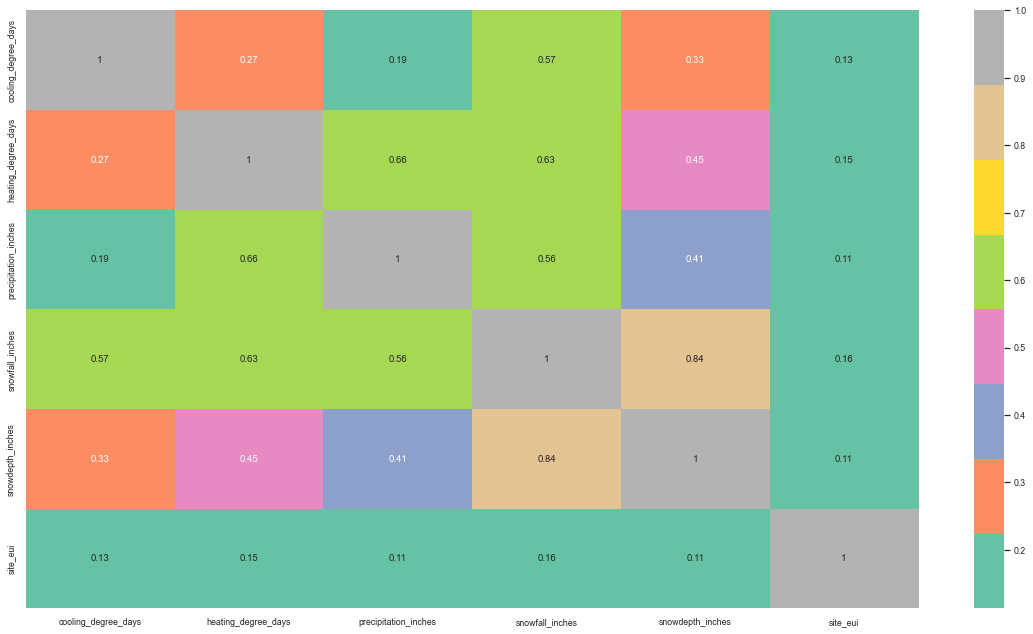

In [67]:
season_cols.append('site_eui')
plt.figure(figsize=(20,11))
sns.set(font_scale=0.8)
sns.heatmap(data[season_cols].corr(), annot=True, cmap = 'Set2')

> * _cooling_degree_days_ , _heating_degree_days_ and _snowfall_inches_ has more impact than the snow inches and depth on the site_eui readings.

* Observations for Cold and Hot days 

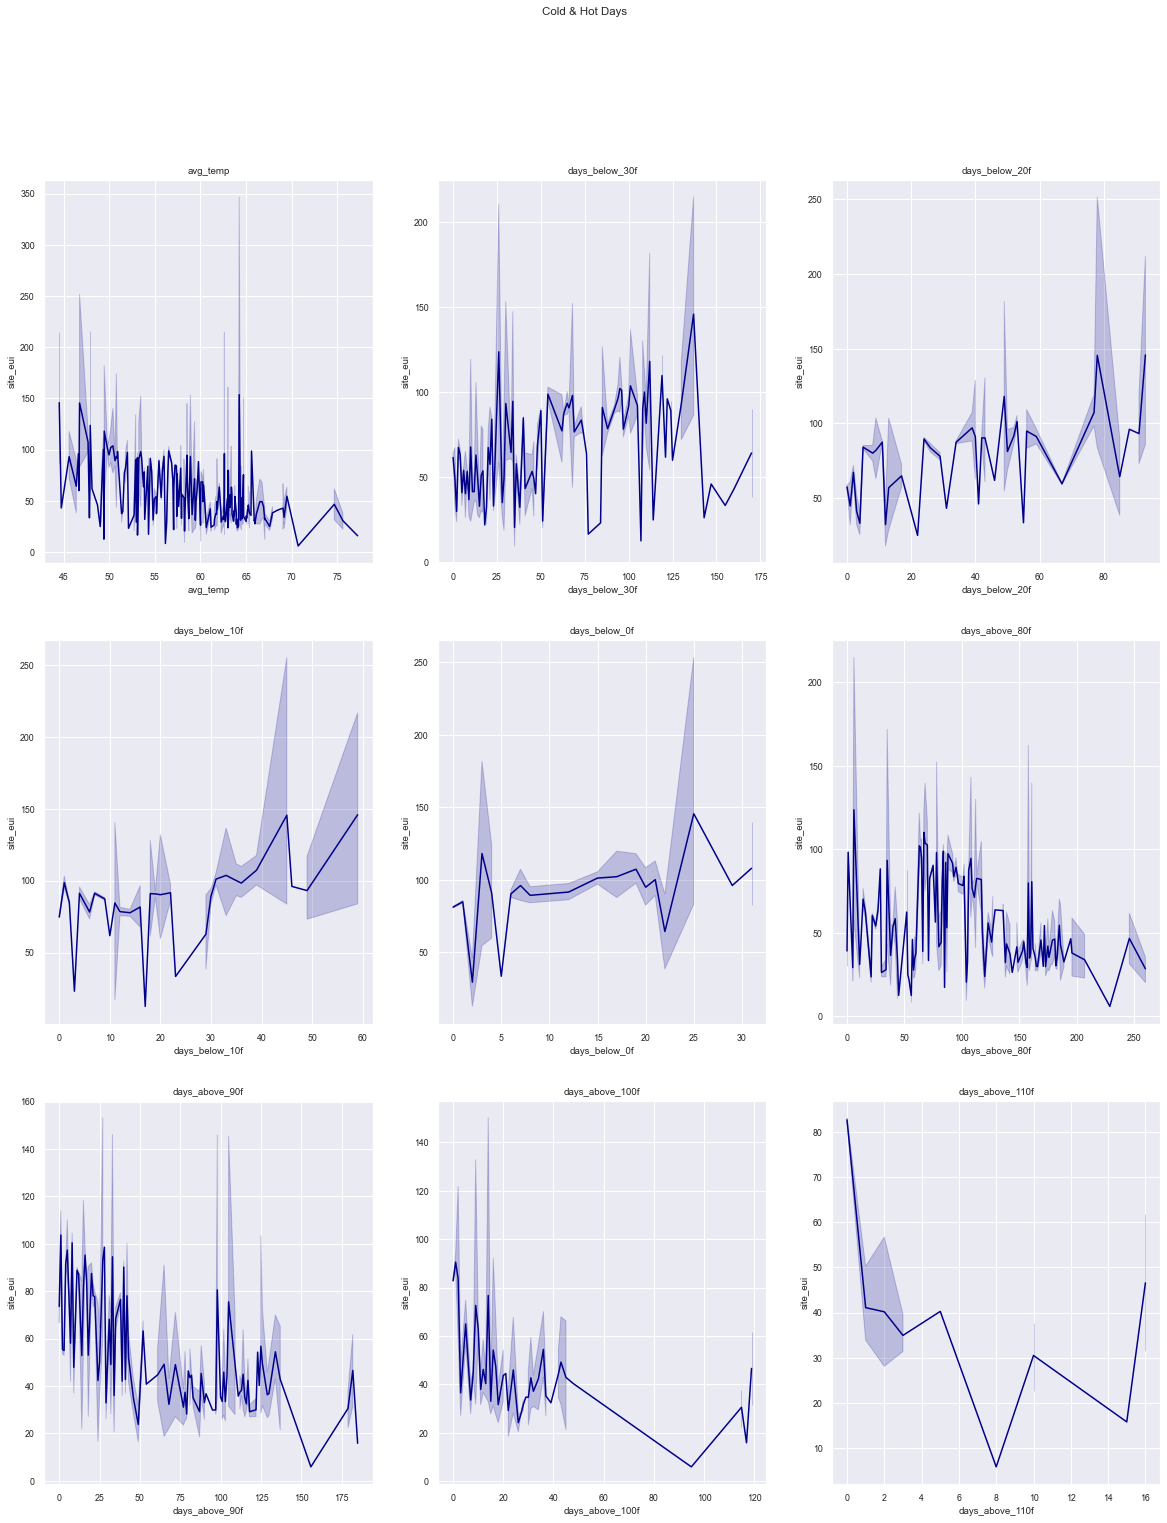

In [68]:
days = ['avg_temp', 'days_below_30f', 'days_below_20f', 'days_below_10f', 'days_below_0f', 'days_above_80f', 'days_above_90f',
       'days_above_100f', 'days_above_110f']

fig = plt.figure(figsize=(20,24))
fig.suptitle("Cold & Hot Days")
fig.tight_layout()
for i, col in enumerate(days):
    plt.subplot(3,3,i+1)
    plt.title(col)
    sns.lineplot(data = data, x=col,y='site_eui', color='darkblue')
    #sns.lmplot(x=col, y="site_eui", data=data, x_estimator=np.mean);
plt.show()

<AxesSubplot:>

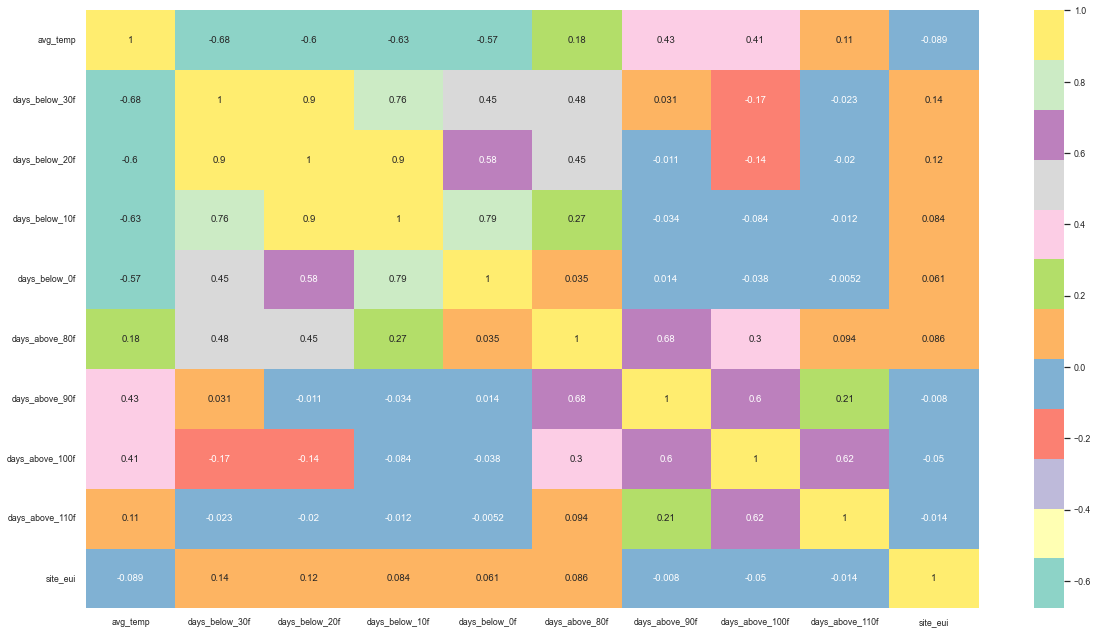

In [69]:
days.append('site_eui')
plt.figure(figsize=(20,11))
sns.set(font_scale=0.8)
sns.heatmap(data[days].corr(), annot=True, cmap = 'Set3')

> * _days_below_30F_ and _days_above_80F_ are more impactful. _days_below_20F has high variance factor hence its less reliable .

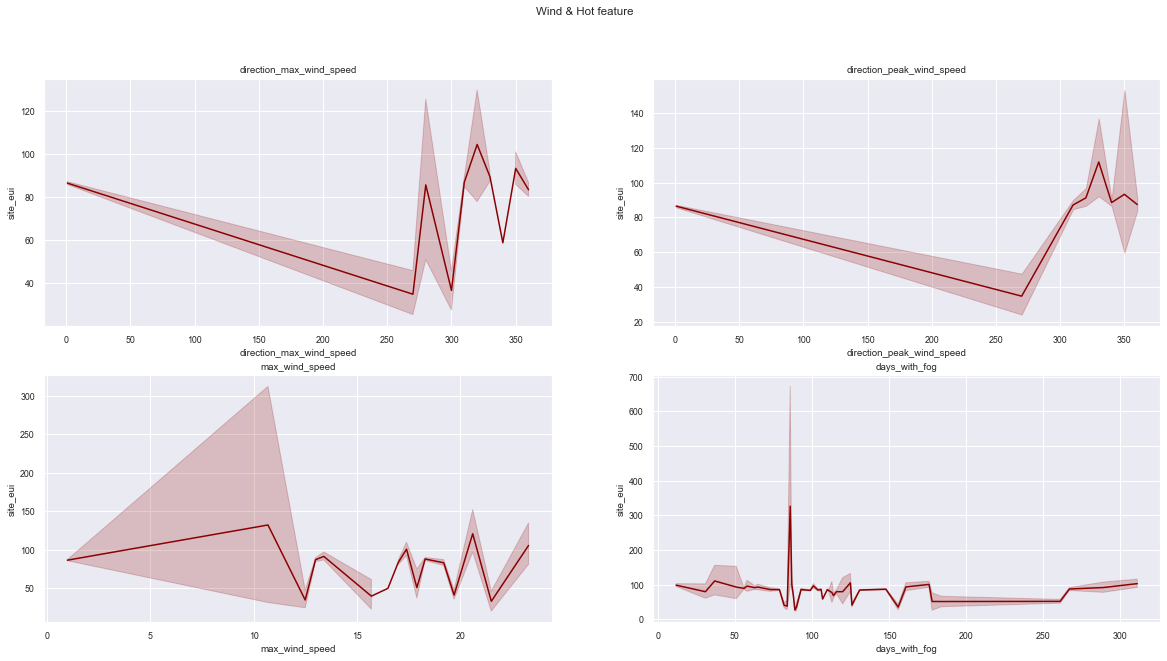

In [70]:
wind_fog = ['direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
fig = plt.figure(figsize=(20,10))
fig.suptitle("Wind & Hot feature")
for i, col in enumerate(wind_fog):
    plt.subplot(2,2,i+1)
    plt.title(col)
    sns.lineplot(data = data, x=col,y='site_eui',color='darkred')
    #sns.lmplot(x=col, y="site_eui", data=data, x_estimator=np.mean);
plt.show()

<AxesSubplot:>

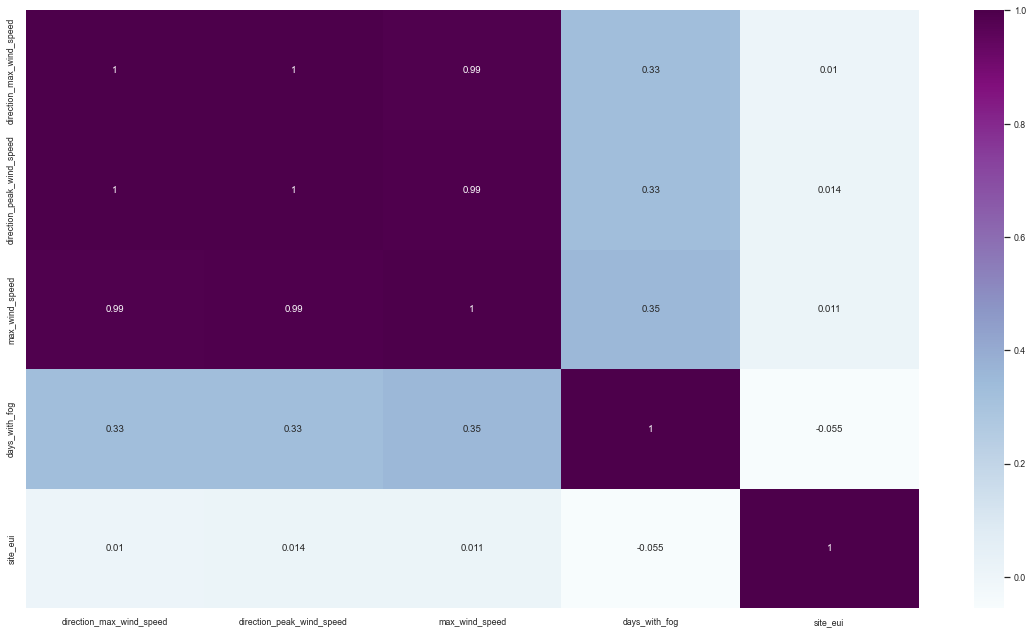

In [71]:
wind_fog.append('site_eui')
plt.figure(figsize=(20,11))
sns.set(font_scale=0.8)
sns.heatmap(data[wind_fog].corr(), annot=True, cmap = 'BuPu')

> * _days_with_fog_ is highly correlated but has negative effect

### Pre-processing


* KNN Imputing

In [72]:
prep_train= temp_df.copy()
prep_xtest = x_test.copy()

In [73]:
prep_train.head()

year_factor state_factor building_class  \
0            1      State_1     Commercial   
1            1      State_1     Commercial   
2            1      State_1     Commercial   
3            1      State_1     Commercial   
4            1      State_1     Commercial   

                               facility_type  floor_area  year_built  \
0               Grocery_store_or_food_market     61242.0      1942.0   
1  Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                       Retail_Enclosed_mall    280025.0      1951.0   
3                  Education_Other_classroom     55325.0      1980.0   
4                  Warehouse_Nonrefrigerated     66000.0      1985.0   

   energy_star_rating  elevation  january_min_temp  january_avg_temp  ...  \
0                11.0        2.4                36              50.5  ...   
1                45.0        1.8                36              50.5  ...   
2                97.0        1.8                36              50.5  ...   
3                46.0        1.8                36              50.5  ...   
4               100.0        2.4                36              50.5  ...   

   days_below_0f  days_above_80f  days_above_90f  days_above_100f  \
0              0              14               0                0   
1              0              14               0                0   
2              0              14               0                0   
3              0              14               0                0   
4              0              14               0                0   

   days_above_110f  direction_max_wind_speed  direction_peak_wind_speed  \
0                0                       1.0                        1.0   
1                0                       1.0                        NaN   
2                0                       1.0                        NaN   
3                0                       1.0                        NaN   
4                0                       1.0                        1.0   

   max_wind_speed  days_with_fog    site_eui  
0             1.0            NaN  248.682615  
1             1.0           12.0   26.500150  
2             1.0           12.0   24.693619  
3             1.0           12.0   48.406926  
4             1.0            NaN    3.899395  

[5 rows x 63 columns]

In [74]:
ctg = ['state_factor', 'building_class']
state_factor=[]
facility_type=fp
building_class=[]
for i,col in enumerate(ctg):
    vals = prep_train[col].unique().tolist()
    if i==0:
        state_factor=vals
    else:
        building_class=vals
print(building_class)

['Commercial', 'Residential']


* Storing facility type labels for deployment use

In [75]:
facility_labels = pd.DataFrame(fp)

In [76]:
facility_labels.to_pickle('facility.pkl')    #to save the dataframe, df to 123.pkl
#facility = pd.read_pickle('facility.pkl')

In [77]:
prep_train['State_Factor'] = prep_train['state_factor'].apply(lambda x: state_factor.index(x) if not pd.isnull(x) else np.nan)
prep_train['Building_Class'] = prep_train['building_class'].apply(lambda x: building_class.index(x) if not pd.isnull(x) else np.nan)

In [78]:

prep_train['Facility_Type'] = prep_train['facility_type'].apply(lambda x: fp.get_loc(x, method=None, tolerance=None) if not pd.isnull(x) else np.nan)


In [79]:
prep_train['Facility_Type'].unique()

array([56,  6, 30, 16,  5,  0, 17, 59, 28, 15, 41, 36, 44, 58, 42, 10, 19,
       34, 37,  9, 57, 20, 18,  8, 26, 27, 14, 38, 50,  7, 40, 39, 29, 46,
       53,  1, 31, 55, 49, 12, 48, 33, 11,  4, 25, 21, 35, 24, 47, 23, 45,
       52, 54, 43, 22, 32, 51, 13,  2,  3], dtype=int64)

In [80]:
prep_train.head()

year_factor state_factor building_class  \
0            1      State_1     Commercial   
1            1      State_1     Commercial   
2            1      State_1     Commercial   
3            1      State_1     Commercial   
4            1      State_1     Commercial   

                               facility_type  floor_area  year_built  \
0               Grocery_store_or_food_market     61242.0      1942.0   
1  Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                       Retail_Enclosed_mall    280025.0      1951.0   
3                  Education_Other_classroom     55325.0      1980.0   
4                  Warehouse_Nonrefrigerated     66000.0      1985.0   

   energy_star_rating  elevation  january_min_temp  january_avg_temp  ...  \
0                11.0        2.4                36              50.5  ...   
1                45.0        1.8                36              50.5  ...   
2                97.0        1.8                36              50.5  ...   
3                46.0        1.8                36              50.5  ...   
4               100.0        2.4                36              50.5  ...   

   days_above_100f  days_above_110f  direction_max_wind_speed  \
0                0                0                       1.0   
1                0                0                       1.0   
2                0                0                       1.0   
3                0                0                       1.0   
4                0                0                       1.0   

   direction_peak_wind_speed  max_wind_speed  days_with_fog    site_eui  \
0                        1.0             1.0            NaN  248.682615   
1                        NaN             1.0           12.0   26.500150   
2                        NaN             1.0           12.0   24.693619   
3                        NaN             1.0           12.0   48.406926   
4                        1.0             1.0            NaN    3.899395   

   State_Factor  Building_Class  Facility_Type  
0             0               0             56  
1             0               0              6  
2             0               0             30  
3             0               0             16  
4             0               0              5  

[5 rows x 66 columns]

In [81]:

prep_train.drop(ctg, axis=1, inplace=True)
prep_train.head()

year_factor                              facility_type  floor_area  \
0            1               Grocery_store_or_food_market     61242.0   
1            1  Warehouse_Distribution_or_Shipping_center    274000.0   
2            1                       Retail_Enclosed_mall    280025.0   
3            1                  Education_Other_classroom     55325.0   
4            1                  Warehouse_Nonrefrigerated     66000.0   

   year_built  energy_star_rating  elevation  january_min_temp  \
0      1942.0                11.0        2.4                36   
1      1955.0                45.0        1.8                36   
2      1951.0                97.0        1.8                36   
3      1980.0                46.0        1.8                36   
4      1985.0               100.0        2.4                36   

   january_avg_temp  january_max_temp  february_min_temp  ...  \
0              50.5                68                 35  ...   
1              50.5                68                 35  ...   
2              50.5                68                 35  ...   
3              50.5                68                 35  ...   
4              50.5                68                 35  ...   

   days_above_100f  days_above_110f  direction_max_wind_speed  \
0                0                0                       1.0   
1                0                0                       1.0   
2                0                0                       1.0   
3                0                0                       1.0   
4                0                0                       1.0   

   direction_peak_wind_speed  max_wind_speed  days_with_fog    site_eui  \
0                        1.0             1.0            NaN  248.682615   
1                        NaN             1.0           12.0   26.500150   
2                        NaN             1.0           12.0   24.693619   
3                        NaN             1.0           12.0   48.406926   
4                        1.0             1.0            NaN    3.899395   

   State_Factor  Building_Class  Facility_Type  
0             0               0             56  
1             0               0              6  
2             0               0             30  
3             0               0             16  
4             0               0              5  

[5 rows x 64 columns]

In [82]:
prep_train.drop('facility_type', axis=1, inplace=True)

In [83]:
prep_train['State_Factor'].unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [84]:
print_null(prep_train)

year_built  =>  1837
energy_star_rating  =>  26709
direction_max_wind_speed  =>  41082
direction_peak_wind_speed  =>  41811
max_wind_speed  =>  41082
days_with_fog  =>  45796


In [85]:
import joblib

def KNN_Imputing(df,knn_imputing,train):

    if knn_imputing:
        imputer = KNNImputer(n_neighbors=7)
        imputed= pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
        
        if train:
            df.to_csv('../Dataset/df_train.csv', index=False)
            imputed.to_csv('../Dataset/imputed_train.csv', index=False)
            joblib.dump(imputer, '../Model/knn_imputer_train.pkl')
        else:
            df.to_csv('../Dataset/df_test.csv', index=False)
            imputed.to_csv('../Dataset/imputed_test.csv', index=False)
            joblib.dump(imputer, '../Model/knn_imputer_test.pkl')

    else:
        df= pd.DataFrame()
        if train:
            df1 = pd.read_csv('../Dataset/imputed_train.csv')
        else:
            df1 = pd.read_csv('../Dataset/imputed_test.csv')
            
        for col in df1.columns:
            df[col] = df1[col]
            
    return df
    

In [82]:
#prep_train = KNN_Imputing(prep_train,knn_imputing=True,train=True)


In [4]:
#prep_train= pd.DataFrame()
#prep_xtest = pd.DataFrame()

In [87]:
prep_train = KNN_Imputing(prep_train,knn_imputing=False,train=True)

In [88]:
prep_train.head()

year_factor  floor_area  year_built  energy_star_rating  elevation  \
0          1.0     61242.0      1942.0                11.0        2.4   
1          1.0    274000.0      1955.0                45.0        1.8   
2          1.0    280025.0      1951.0                97.0        1.8   
3          1.0     55325.0      1980.0                46.0        1.8   
4          1.0     66000.0      1985.0               100.0        2.4   

   january_min_temp  january_avg_temp  january_max_temp  february_min_temp  \
0              36.0              50.5              68.0               35.0   
1              36.0              50.5              68.0               35.0   
2              36.0              50.5              68.0               35.0   
3              36.0              50.5              68.0               35.0   
4              36.0              50.5              68.0               35.0   

   february_avg_temp  ...  days_above_100f  days_above_110f  \
0          50.589286  ...              0.0              0.0   
1          50.589286  ...              0.0              0.0   
2          50.589286  ...              0.0              0.0   
3          50.589286  ...              0.0              0.0   
4          50.589286  ...              0.0              0.0   

   direction_max_wind_speed  direction_peak_wind_speed  max_wind_speed  \
0                       1.0                        1.0             1.0   
1                       1.0                        1.0             1.0   
2                       1.0                        1.0             1.0   
3                       1.0                        1.0             1.0   
4                       1.0                        1.0             1.0   

   days_with_fog    site_eui  State_Factor  Building_Class  Facility_Type  
0     186.857143  248.682615           0.0             0.0           56.0  
1      12.000000   26.500150           0.0             0.0            6.0  
2      12.000000   24.693619           0.0             0.0           30.0  
3      12.000000   48.406926           0.0             0.0           16.0  
4     137.428571    3.899395           0.0             0.0            5.0  

[5 rows x 63 columns]

In [89]:
print_null(prep_train)

In [91]:
def preprocess_testdata(df):
    #df.columns = df.columns.str.lower()
    #df['State_Factor'] = df['state_factor'].apply(lambda x: state_factor.index(x) if not pd.isnull(x) else np.nan)
    #df['Facility_Type'] = df['facility_type'].apply(lambda x: fp.get_loc(x, method=None, tolerance=None) if not pd.isnull(x) else np.nan)
    #df['Building_Class'] = df['building_class'].apply(lambda x: building_class.index(x) if not pd.isnull(x) else np.nan)
    #df = df.drop(ctg, axis=1)
    #df.drop('facility_type', axis=1, inplace=True)
    #df = KNN_Imputing(df,knn_imputing=True,train=False)
    df = KNN_Imputing(df,knn_imputing=False,train=False)
    #print_null(df)
    return df
    

In [92]:
prep_xtest = preprocess_testdata(prep_xtest)

In [93]:
prep_xtest.head()

year_factor  floor_area  year_built  energy_star_rating  elevation  \
0          7.0     28484.0      1994.0                37.0        2.4   
1          7.0     21906.0      1961.0                55.0       45.7   
2          7.0     16138.0      1950.0                 1.0       59.1   
3          7.0     97422.0      1971.0                34.0       35.4   
4          7.0     61242.0      1942.0                35.0        1.8   

   january_min_temp  january_avg_temp  january_max_temp  february_min_temp  \
0              38.0         50.596774              64.0               40.0   
1              38.0         50.596774              64.0               40.0   
2              38.0         50.596774              64.0               40.0   
3              38.0         50.596774              64.0               40.0   
4              38.0         50.596774              64.0               40.0   

   february_avg_temp  ...  days_above_90f  days_above_100f  days_above_110f  \
0          54.482143  ...             5.0              2.0              0.0   
1          54.482143  ...             5.0              2.0              0.0   
2          54.482143  ...             5.0              2.0              0.0   
3          54.482143  ...             5.0              2.0              0.0   
4          54.482143  ...             5.0              2.0              0.0   

   direction_max_wind_speed  direction_peak_wind_speed  max_wind_speed  \
0                310.000000                 257.142857       16.185714   
1                310.000000                 274.285714       17.571429   
2                310.000000                 291.428571       18.957143   
3                314.285714                 291.428571       16.371429   
4                340.000000                 330.000000       22.800000   

   days_with_fog  State_Factor  Facility_Type  Building_Class  
0     232.285714           0.0           56.0             0.0  
1     214.571429           0.0           56.0             0.0  
2     196.857143           0.0           56.0             0.0  
3     163.571429           0.0           56.0             0.0  
4     126.000000           0.0           56.0             0.0  

[5 rows x 62 columns]

### Feature Engineering

In [94]:
feature_train = prep_train.copy()
feature_test = prep_xtest.copy()

* Correlation Heatmap

Text(0.5, 1.0, 'Correlation Heatmap')

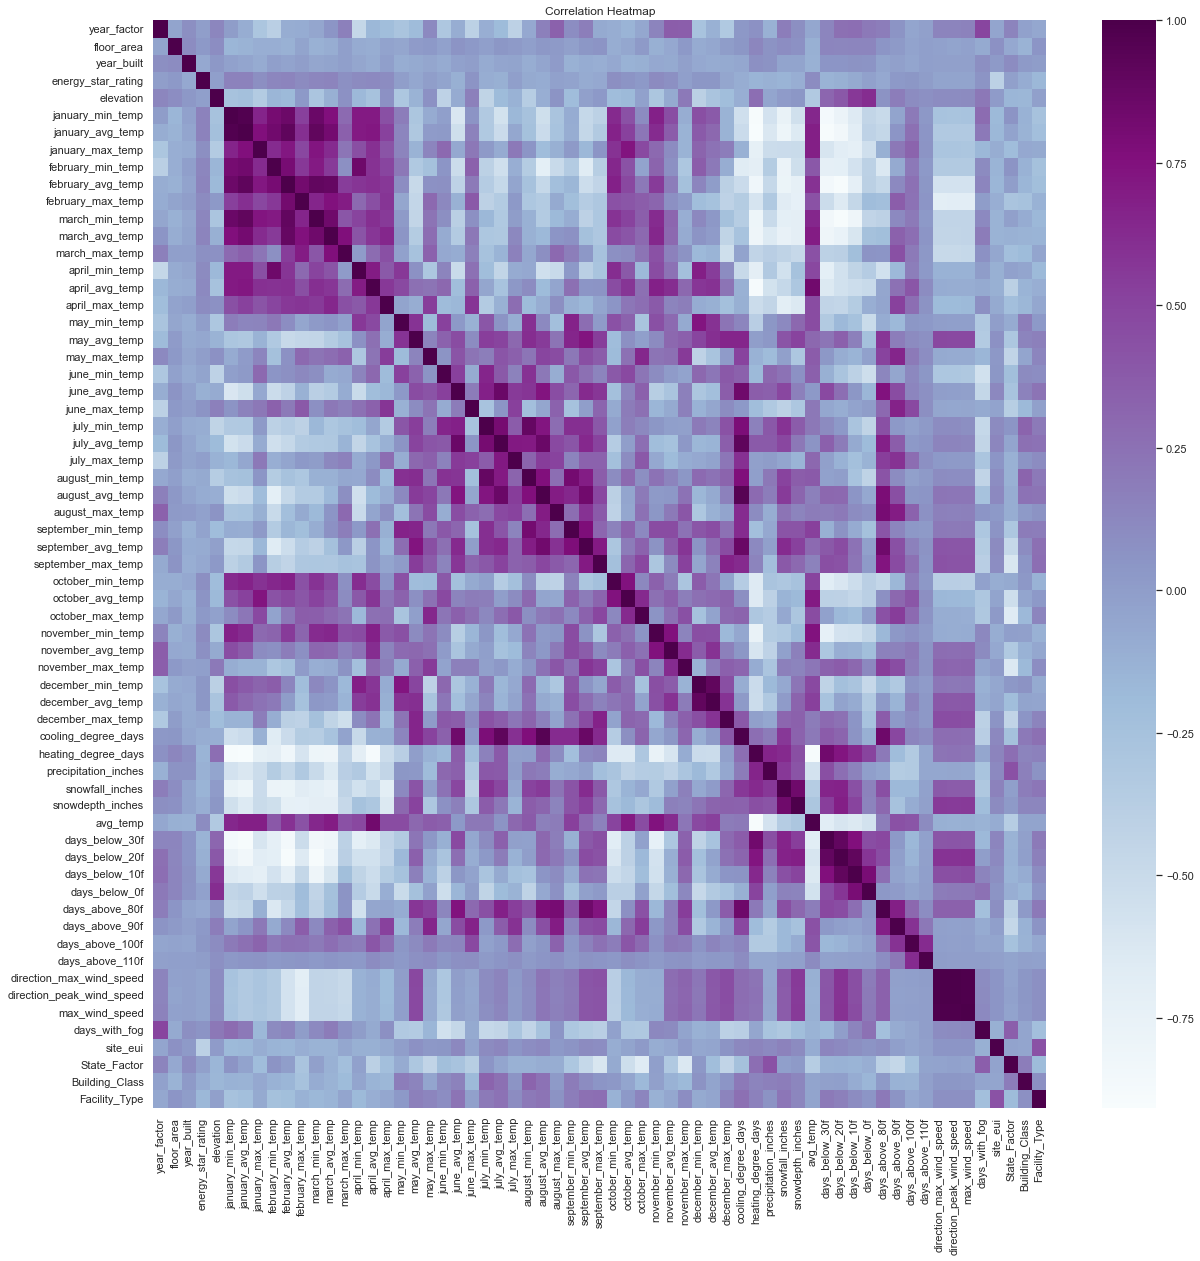

In [95]:
fig = plt.figure(figsize=(20,20))
corr_p = feature_train.corr(method='pearson')
sns.set(font_scale=1)
sns.heatmap(corr_p,  cmap ='BuPu',annot = False)
plt.title("Correlation Heatmap")

> We can see that grouping the _facility_type_ properly has increased its correlation with site_eui

In [96]:
corr = corr_p['site_eui']
corr.sort_values()

energy_star_rating    -0.406714
january_min_temp      -0.179190
january_avg_temp      -0.167982
february_avg_temp     -0.154071
february_min_temp     -0.147348
                         ...   
days_below_30f         0.139811
heating_degree_days    0.147861
snowfall_inches        0.157284
Facility_Type          0.422621
site_eui               1.000000
Name: site_eui, Length: 63, dtype: float64

In [97]:
def list_highly_correlated(df):
    cor_matrix = df.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.98)]
    print(to_drop)
    return to_drop

In [98]:
hcd = list_highly_correlated(feature_train)

['direction_peak_wind_speed', 'max_wind_speed']


In [99]:
feature_train.drop(hcd,axis=1,inplace=True)
feature_test.drop(hcd,axis=1,inplace=True)

* avg_temp has more insight than the max an min temp

In [100]:
print(feature_train.shape)
cols = feature_train.filter(like='min_temp',axis=1).columns
feature_train.drop(cols,axis=1,inplace=True)
feature_test.drop(cols,axis=1,inplace=True)

cols = feature_train.filter(like='max_temp',axis=1).columns
feature_train.drop(cols,axis=1,inplace=True)
feature_test.drop(cols,axis=1,inplace=True)
print('===== After removing Min and Max temp =====')
print(feature_train.shape)

(75757, 61)
===== After removing Min and Max temp =====
(75757, 37)


In [101]:
feature_train['summer']=(feature_train['january_avg_temp']+feature_train['february_avg_temp']+feature_train['march_avg_temp']+feature_train['april_avg_temp'])/4
feature_train['rainy']=(feature_train['may_avg_temp']+feature_train['june_avg_temp']+feature_train['july_avg_temp']+feature_train['august_avg_temp']+feature_train['september_avg_temp'])/5
feature_train['winter']=(feature_train['october_avg_temp']+feature_train['november_avg_temp']+feature_train['december_avg_temp'])/3
cols = feature_train.filter(like='_avg_temp',axis=1).columns
feature_train.drop(cols,axis=1,inplace=True)
feature_train.head()

year_factor  floor_area  year_built  energy_star_rating  elevation  \
0          1.0     61242.0      1942.0                11.0        2.4   
1          1.0    274000.0      1955.0                45.0        1.8   
2          1.0    280025.0      1951.0                97.0        1.8   
3          1.0     55325.0      1980.0                46.0        1.8   
4          1.0     66000.0      1985.0               100.0        2.4   

   cooling_degree_days  heating_degree_days  precipitation_inches  \
0                115.0               2960.0                 16.59   
1                115.0               2960.0                 16.59   
2                115.0               2960.0                 16.59   
3                115.0               2960.0                 16.59   
4                115.0               2960.0                 16.59   

   snowfall_inches  snowdepth_inches  ...  days_above_110f  \
0              0.0               0.0  ...              0.0   
1              0.0               0.0  ...              0.0   
2              0.0               0.0  ...              0.0   
3              0.0               0.0  ...              0.0   
4              0.0               0.0  ...              0.0   

   direction_max_wind_speed  days_with_fog    site_eui  State_Factor  \
0                       1.0     186.857143  248.682615           0.0   
1                       1.0      12.000000   26.500150           0.0   
2                       1.0      12.000000   24.693619           0.0   
3                       1.0      12.000000   48.406926           0.0   
4                       1.0     137.428571    3.899395           0.0   

   Building_Class  Facility_Type     summer      rainy     winter  
0             0.0           56.0  52.570709  61.378387  55.363441  
1             0.0            6.0  52.570709  61.378387  55.363441  
2             0.0           30.0  52.570709  61.378387  55.363441  
3             0.0           16.0  52.570709  61.378387  55.363441  
4             0.0            5.0  52.570709  61.378387  55.363441  

[5 rows x 28 columns]

In [102]:
feature_test['summer']=(feature_test['january_avg_temp']+feature_test['february_avg_temp']+feature_test['march_avg_temp']+feature_test['april_avg_temp'])/4
feature_test['rainy']=(feature_test['may_avg_temp']+feature_test['june_avg_temp']+feature_test['july_avg_temp']+feature_test['august_avg_temp']+feature_test['september_avg_temp'])/5
feature_test['winter']=(feature_test['october_avg_temp']+feature_test['november_avg_temp']+feature_test['december_avg_temp'])/3
cols = feature_test.filter(like='_avg_temp',axis=1).columns
feature_test.drop(cols,axis=1,inplace=True)
feature_test.head()

year_factor  floor_area  year_built  energy_star_rating  elevation  \
0          7.0     28484.0      1994.0                37.0        2.4   
1          7.0     21906.0      1961.0                55.0       45.7   
2          7.0     16138.0      1950.0                 1.0       59.1   
3          7.0     97422.0      1971.0                34.0       35.4   
4          7.0     61242.0      1942.0                35.0        1.8   

   cooling_degree_days  heating_degree_days  precipitation_inches  \
0                342.0               2112.0                 25.24   
1                342.0               2112.0                 25.24   
2                342.0               2112.0                 25.24   
3                342.0               2112.0                 25.24   
4                342.0               2112.0                 25.24   

   snowfall_inches  snowdepth_inches  ...  days_above_100f  days_above_110f  \
0              0.0               0.0  ...              2.0              0.0   
1              0.0               0.0  ...              2.0              0.0   
2              0.0               0.0  ...              2.0              0.0   
3              0.0               0.0  ...              2.0              0.0   
4              0.0               0.0  ...              2.0              0.0   

   direction_max_wind_speed  days_with_fog  State_Factor  Facility_Type  \
0                310.000000     232.285714           0.0           56.0   
1                310.000000     214.571429           0.0           56.0   
2                310.000000     196.857143           0.0           56.0   
3                314.285714     163.571429           0.0           56.0   
4                340.000000     126.000000           0.0           56.0   

   Building_Class   summer      rainy     winter  
0             0.0  55.1161  64.786559  58.043548  
1             0.0  55.1161  64.786559  58.043548  
2             0.0  55.1161  64.786559  58.043548  
3             0.0  55.1161  64.786559  58.043548  
4             0.0  55.1161  64.786559  58.043548  

[5 rows x 27 columns]

In [103]:
from datetime import date
feature_train['site_age']= date.today().year-feature_train['year_built']
feature_train.drop('year_built', axis=1, inplace=True)
feature_train.head()

year_factor  floor_area  energy_star_rating  elevation  \
0          1.0     61242.0                11.0        2.4   
1          1.0    274000.0                45.0        1.8   
2          1.0    280025.0                97.0        1.8   
3          1.0     55325.0                46.0        1.8   
4          1.0     66000.0               100.0        2.4   

   cooling_degree_days  heating_degree_days  precipitation_inches  \
0                115.0               2960.0                 16.59   
1                115.0               2960.0                 16.59   
2                115.0               2960.0                 16.59   
3                115.0               2960.0                 16.59   
4                115.0               2960.0                 16.59   

   snowfall_inches  snowdepth_inches   avg_temp  ...  \
0              0.0               0.0  56.972603  ...   
1              0.0               0.0  56.972603  ...   
2              0.0               0.0  56.972603  ...   
3              0.0               0.0  56.972603  ...   
4              0.0               0.0  56.972603  ...   

   direction_max_wind_speed  days_with_fog    site_eui  State_Factor  \
0                       1.0     186.857143  248.682615           0.0   
1                       1.0      12.000000   26.500150           0.0   
2                       1.0      12.000000   24.693619           0.0   
3                       1.0      12.000000   48.406926           0.0   
4                       1.0     137.428571    3.899395           0.0   

   Building_Class  Facility_Type     summer      rainy     winter  site_age  
0             0.0           56.0  52.570709  61.378387  55.363441      80.0  
1             0.0            6.0  52.570709  61.378387  55.363441      67.0  
2             0.0           30.0  52.570709  61.378387  55.363441      71.0  
3             0.0           16.0  52.570709  61.378387  55.363441      42.0  
4             0.0            5.0  52.570709  61.378387  55.363441      37.0  

[5 rows x 28 columns]

In [104]:
feature_test['site_age']= date.today().year-feature_test['year_built']
feature_test.drop('year_built', axis=1, inplace=True)
feature_test.head()

year_factor  floor_area  energy_star_rating  elevation  \
0          7.0     28484.0                37.0        2.4   
1          7.0     21906.0                55.0       45.7   
2          7.0     16138.0                 1.0       59.1   
3          7.0     97422.0                34.0       35.4   
4          7.0     61242.0                35.0        1.8   

   cooling_degree_days  heating_degree_days  precipitation_inches  \
0                342.0               2112.0                 25.24   
1                342.0               2112.0                 25.24   
2                342.0               2112.0                 25.24   
3                342.0               2112.0                 25.24   
4                342.0               2112.0                 25.24   

   snowfall_inches  snowdepth_inches   avg_temp  ...  days_above_110f  \
0              0.0               0.0  59.894521  ...              0.0   
1              0.0               0.0  59.894521  ...              0.0   
2              0.0               0.0  59.894521  ...              0.0   
3              0.0               0.0  59.894521  ...              0.0   
4              0.0               0.0  59.894521  ...              0.0   

   direction_max_wind_speed  days_with_fog  State_Factor  Facility_Type  \
0                310.000000     232.285714           0.0           56.0   
1                310.000000     214.571429           0.0           56.0   
2                310.000000     196.857143           0.0           56.0   
3                314.285714     163.571429           0.0           56.0   
4                340.000000     126.000000           0.0           56.0   

   Building_Class   summer      rainy     winter  site_age  
0             0.0  55.1161  64.786559  58.043548      28.0  
1             0.0  55.1161  64.786559  58.043548      61.0  
2             0.0  55.1161  64.786559  58.043548      72.0  
3             0.0  55.1161  64.786559  58.043548      51.0  
4             0.0  55.1161  64.786559  58.043548      80.0  

[5 rows x 27 columns]

In [105]:
feature_train['total_area'] = feature_train['floor_area'] * feature_train['elevation']
feature_test['total_area'] = feature_test['floor_area'] * feature_test['elevation']

In [106]:
corr=feature_train.corr()
corr.style.background_gradient(cmap='coolwarm')

---

In [107]:
#Compute VIF data for each independent variable
import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["features"] = feature_train.columns
vif["vif_Factor"] = [variance_inflation_factor(feature_train.values, i) for i in range(feature_train.shape[1])]


In [108]:
vi = vif
print(vi.sort_values(by='vif_Factor',ascending=False))

                    features    vif_Factor
9                   avg_temp  2.386706e+06
25                     rainy  7.044017e+05
24                    summer  2.622537e+03
5        heating_degree_days  1.853716e+03
26                    winter  6.096026e+02
4        cooling_degree_days  5.057467e+02
11            days_below_20f  1.874718e+02
6       precipitation_inches  1.566330e+02
7            snowfall_inches  8.217888e+01
21              State_Factor  3.965605e+01
12            days_below_10f  3.890452e+01
0                year_factor  3.770286e+01
10            days_below_30f  3.600266e+01
8           snowdepth_inches  2.918961e+01
14            days_above_80f  2.192346e+01
15            days_above_90f  1.868796e+01
13             days_below_0f  1.078045e+01
16           days_above_100f  5.497522e+00
18  direction_max_wind_speed  3.493387e+00
28                total_area  2.766225e+00
19             days_with_fog  2.711397e+00
17           days_above_110f  2.166151e+00
3          

<AxesSubplot:xlabel='features'>

<Figure size 1440x1440 with 0 Axes>

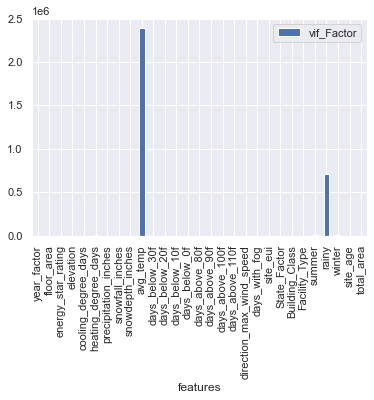

In [109]:
fig = plt.figure(figsize=(20,20))
vif.plot(x ='features', y='vif_Factor', kind = 'bar')

In [110]:
def print_target_corr(df):
    cor_matrix = df.corr()
    upper_tri = cor_matrix['site_eui']
    print(upper_tri.sort_values(axis=0))
    pass
print_target_corr(feature_train)

energy_star_rating         -0.406714
summer                     -0.159837
days_with_fog              -0.113815
avg_temp                   -0.089201
winter                     -0.067604
days_above_100f            -0.050029
Building_Class             -0.046794
year_factor                -0.045179
State_Factor               -0.033496
site_age                   -0.018890
days_above_110f            -0.014190
days_above_90f             -0.007980
elevation                   0.011798
total_area                  0.043377
direction_max_wind_speed    0.047427
days_below_0f               0.060981
floor_area                  0.073967
days_below_10f              0.084296
days_above_80f              0.086347
snowdepth_inches            0.113371
precipitation_inches        0.113558
days_below_20f              0.119492
cooling_degree_days         0.125004
rainy                       0.128733
days_below_30f              0.139811
heating_degree_days         0.147861
snowfall_inches             0.157284
F

In [111]:
high_corr = list_highly_correlated(feature_train)
print(high_corr)

['rainy']
['rainy']


In [112]:
final_cols = ['snowfall_inches', 'heating_degree_days', 'rainy', 'cooling_degree_days',
            'days_below_30f', 'days_below_20f', 'summer', 'precipitation_inches', 'avg_temp',
            'snowdepth_inches', 'days_above_80f','days_below_10f']
            #
#add_cols = ['facility_type']
#, 'floor_area','site_age',, 'building_class' 
#final_cols.extend(add_cols)
final_cols


['snowfall_inches',
 'heating_degree_days',
 'rainy',
 'cooling_degree_days',
 'days_below_30f',
 'days_below_20f',
 'summer',
 'precipitation_inches',
 'avg_temp',
 'snowdepth_inches',
 'days_above_80f',
 'days_below_10f']

Text(0.5, 1.0, 'Correlation Heatmap for days')

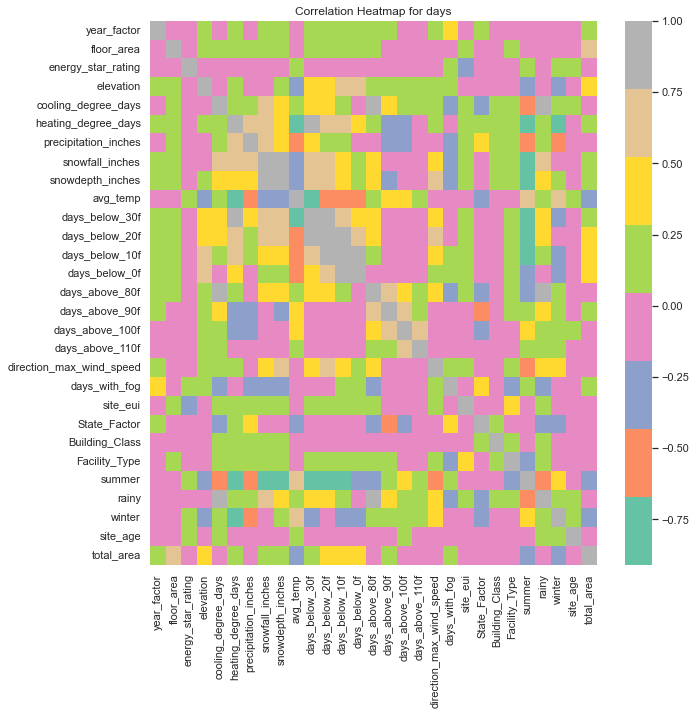

In [114]:
fig = plt.figure(figsize=(10,10))
corr_p2 = feature_train.corr()
sns.heatmap(corr_p2,  cmap ='Set2',annot = False)
plt.title("Correlation Heatmap for days")

In [115]:
feature_train.sort_index(axis=1,inplace=True)
feature_test.sort_index(axis=1,inplace=True)
feature_train.columns = feature_train.columns.str.lower()
feature_test.columns = feature_test.columns.str.lower()


In [122]:
X_train = feature_train[final_cols].copy()
y_train = pd.DataFrame(feature_train['site_eui'])

X_test = feature_test[final_cols].copy()

In [120]:
y_test.drop('id', axis=1, inplace=True)


KeyError: "['id'] not found in axis"

In [123]:
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

Train:  (75757, 12)
Test: (9705, 12)
Samples:  (75757, 1)
Targets:  (9705, 1)


In [124]:
X_test.columns

Index(['snowfall_inches', 'heating_degree_days', 'rainy',
       'cooling_degree_days', 'days_below_30f', 'days_below_20f', 'summer',
       'precipitation_inches', 'avg_temp', 'snowdepth_inches',
       'days_above_80f', 'days_below_10f'],
      dtype='object')

In [125]:
X_train.columns

Index(['snowfall_inches', 'heating_degree_days', 'rainy',
       'cooling_degree_days', 'days_below_30f', 'days_below_20f', 'summer',
       'precipitation_inches', 'avg_temp', 'snowdepth_inches',
       'days_above_80f', 'days_below_10f'],
      dtype='object')

### Baseline Model

* CatBoost

['snowfall_inches', 'heating_degree_days', 'rainy',
       'cooling_degree_days', 'days_below_30f', 'days_below_20f', 'summer',
       'precipitation_inches', 'snowdepth_inches', 'days_above_80f',
       'days_below_10f', 'energy_star_rating']


catb = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=13, eval_metric='RMSE', random_seed = 23,
                         bagging_temperature = 0.2, od_type='Iter', metric_period = 75, od_wait=120)


bestTest = 73.54192542
bestIteration = 213
===========================================================================================================================

final_cols = ['snowfall_inches', 'heating_degree_days', 'rainy', 'cooling_degree_days',
            'days_below_30f', 'days_below_20f', 'summer', 'precipitation_inches', 'snowdepth_inches', 'avg_temp', 'days_above_80f','days_below_10f']
catb = CatBoostRegressor(iterations=500, learning_rate=0.046, depth=12, eval_metric='RMSE', random_seed = 21,
                         bagging_temperature = 0.2, od_type='Iter', metric_period = 75, od_wait=120)

  bestTest = 71.6009001
bestIteration = 201                     

catb = CatBoostRegressor(iterations=500, learning_rate=0.065, depth=13, eval_metric='RMSE', random_seed = 19,
                         bagging_temperature = 0.2, od_type='Iter', metric_period = 75, od_wait=120)
bestTest = 69.64687071
bestIteration = 285

In [126]:
catb = CatBoostRegressor(iterations=500, learning_rate=0.065, depth=13, eval_metric='RMSE', random_seed = 19,
                         bagging_temperature = 0.2, od_type='Iter', metric_period = 75, od_wait=120)

catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 use_best_model=True,
                 verbose=True)

y_pred = catb.predict(X_test)                        


0:	learn: 58.1112162	test: 82.3363989	best: 82.3363989 (0)	total: 207ms	remaining: 1m 43s
75:	learn: 56.9737726	test: 71.7642365	best: 71.7335003 (73)	total: 11.8s	remaining: 1m 5s
150:	learn: 56.9682428	test: 70.1365800	best: 70.1365800 (150)	total: 22.2s	remaining: 51.3s
225:	learn: 56.9661700	test: 69.8990828	best: 69.7765984 (183)	total: 33.1s	remaining: 40.1s
300:	learn: 56.9653934	test: 69.6893321	best: 69.6468707 (285)	total: 43.2s	remaining: 28.6s
375:	learn: 56.9651019	test: 70.1355698	best: 69.6468707 (285)	total: 54.6s	remaining: 18s
Stopped by overfitting detector  (120 iterations wait)

bestTest = 69.64687071
bestIteration = 285

Shrink model to first 286 iterations.


In [127]:

print(" --- CatBoost---")
print(" RMSE - ", np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print(" MAE - ", metrics.mean_absolute_error(y_test,y_pred))


 --- CatBoost---
 RMSE -  69.6468707147338
 MAE -  68.85840590891654


* XGBoost

In [128]:
xgb = XGBRegressor(n_estimators=500, reg_alpha=0.01, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [129]:
print(" --- XGBoost---")
print(" RMSE - ", np.sqrt(metrics.mean_squared_error(y_test,y_pred_xgb)))
print(" MAE - ", metrics.mean_absolute_error(y_test,y_pred_xgb))

 --- XGBoost---
 RMSE -  71.13545661308483
 MAE -  70.4466033707569


* Random Forest

In [130]:
rf = RandomForestRegressor(random_state=21, criterion='squared_error', max_depth = 12, min_samples_split= 2)
rf.fit(X_train, y_train)
y_pred_rf = xgb.predict(X_test)

In [131]:
print(" --- Random Forest---")
print(" RMSE - ", np.sqrt(metrics.mean_squared_error(y_test,y_pred_rf)))
print(" MAE - ", metrics.mean_absolute_error(y_test,y_pred_rf))

 --- Random Forest---
 RMSE -  71.13545661308483
 MAE -  70.4466033707569


### Hyper-parameter Tuning

* Optuna with CatBoost

In [135]:


def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X_train, y_train, test_size=0.2, random_state=21, shuffle=True)
    train_pool = Pool(train_x, train_y)
    test_pool = Pool(test_x, test_y)
    
    # Parameters
    params = {
        'iterations' : trial.suggest_int('iterations', 500, 700),                         
        'depth' : trial.suggest_int('depth', 10, 15),                                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 0.03),
        'learning_rate' :trial.suggest_loguniform('learning_rate', 0.01, 0.07),
    }
    # Learning
    model = CatBoostRegressor(
        eval_metric='RMSE', random_seed = 19, od_type='Iter', **params )        
    model.fit(train_pool)
    # Predict
    preds = model.predict(test_pool)
    y_pred_boot = resample(np.rint(preds), n_samples = len(train_y))
    # Evaluation
    ROC_AUC_Score =np.sqrt(metrics.mean_squared_error(train_y, y_pred_boot,squared=False))
    print('ROC AUC Score of CatBoost =', ROC_AUC_Score)
    return ROC_AUC_Score

In [136]:
study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 1 )

[I 2022-03-19 16:01:40,490] A new study created in memory with name: no-name-c931c7e2-0ec7-439d-9d35-3d3b316144f1


0:	learn: 58.2819131	total: 11.1ms	remaining: 7.49s
1:	learn: 58.2549496	total: 35.9ms	remaining: 12.1s
2:	learn: 58.2278673	total: 57.1ms	remaining: 12.7s
3:	learn: 58.2015754	total: 82.4ms	remaining: 13.8s
4:	learn: 58.1758892	total: 107ms	remaining: 14.3s
5:	learn: 58.1505791	total: 131ms	remaining: 14.6s
6:	learn: 58.1265471	total: 152ms	remaining: 14.4s
7:	learn: 58.1019167	total: 172ms	remaining: 14.3s
8:	learn: 58.0785777	total: 193ms	remaining: 14.3s
9:	learn: 58.0558831	total: 220ms	remaining: 14.6s
10:	learn: 58.0335595	total: 243ms	remaining: 14.6s
11:	learn: 58.0118490	total: 270ms	remaining: 14.9s
12:	learn: 57.9902838	total: 295ms	remaining: 15s
13:	learn: 57.9698469	total: 318ms	remaining: 15s
14:	learn: 57.9497691	total: 348ms	remaining: 15.3s
15:	learn: 57.9295213	total: 377ms	remaining: 15.5s
16:	learn: 57.9097817	total: 398ms	remaining: 15.3s
17:	learn: 57.8916466	total: 418ms	remaining: 15.2s
18:	learn: 57.8725498	total: 437ms	remaining: 15s
19:	learn: 57.8546208	to

[I 2022-03-19 16:01:54,923] Trial 0 finished with value: 7.713363474831117 and parameters: {'iterations': 673, 'depth': 10, 'bagging_temperature': 0.022075286979612817, 'learning_rate': 0.012161469929476514}. Best is trial 0 with value: 7.713363474831117.


ROC AUC Score of CatBoost = 7.713363474831117


`code`[I 2022-03-19 16:01:54,923] Trial 0 finished with value: 7.713363474831117 and parameters: {'iterations': 673, 'depth': 10, 'bagging_temperature': 0.022075286979612817, 'learning_rate': 0.012161469929476514}. Best is trial 0 with value: 7.713363474831117.
ROC AUC Score of CatBoost = 7.713363474831117
`code`

In [137]:
print("-----Tuning Parameters------")
best_params = study.best_params
best_score = study.best_value
print(f"Best score - {best_score}")
print(f"Optimized parameters - {best_params}\n")
    

-----Tuning Parameters------
Best score - 7.713363474831117
Optimized parameters - {'iterations': 673, 'depth': 10, 'bagging_temperature': 0.022075286979612817, 'learning_rate': 0.012161469929476514}



In [138]:
tuned_model = CatBoostRegressor(eval_metric='RMSE', random_seed = 19, od_type='Iter', **best_params )   
tuned_model.fit(X_train, y_train)

0:	learn: 58.2274087	total: 27.7ms	remaining: 18.6s
1:	learn: 58.1989706	total: 51.2ms	remaining: 17.2s
2:	learn: 58.1712664	total: 75ms	remaining: 16.7s
3:	learn: 58.1441693	total: 99ms	remaining: 16.6s
4:	learn: 58.1181971	total: 126ms	remaining: 16.9s
5:	learn: 58.0931636	total: 152ms	remaining: 16.9s
6:	learn: 58.0686034	total: 174ms	remaining: 16.6s
7:	learn: 58.0440529	total: 194ms	remaining: 16.2s
8:	learn: 58.0201803	total: 216ms	remaining: 15.9s
9:	learn: 57.9970123	total: 237ms	remaining: 15.7s
10:	learn: 57.9746166	total: 258ms	remaining: 15.6s
11:	learn: 57.9524430	total: 286ms	remaining: 15.7s
12:	learn: 57.9307230	total: 312ms	remaining: 15.8s
13:	learn: 57.9087328	total: 340ms	remaining: 16s
14:	learn: 57.8882790	total: 370ms	remaining: 16.2s
15:	learn: 57.8681530	total: 396ms	remaining: 16.2s
16:	learn: 57.8478793	total: 422ms	remaining: 16.3s
17:	learn: 57.8284675	total: 444ms	remaining: 16.2s
18:	learn: 57.8102741	total: 470ms	remaining: 16.2s
19:	learn: 57.7922098	to

* Evaluation

Text(0.5, 0, 'Iterations')

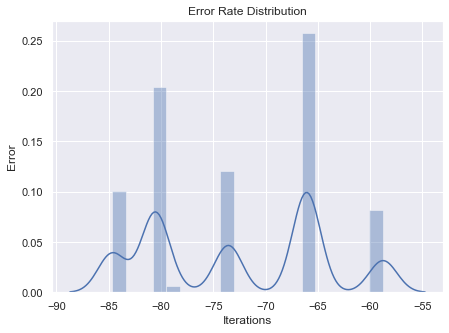

In [151]:
y_hat_tuned = tuned_model.predict(X_test)
yy_test =y_hat_tuned.reshape(-1,1).copy()

plt.figure(figsize = (7,5))
sns.distplot(y_test - yy_test)
plt.title("Error Rate Distribution")
plt.ylabel("Error")
plt.xlabel("Iterations")

In [152]:
with open('../Model/catb__final.joblib', 'wb') as f:
    joblib.dump(tuned_model,f,compress=3)

## Explainable AI

In [153]:
sample_set = X_test.sample(2000)

In [154]:
import shap
shap.initjs()

In [173]:
explainer = shap.TreeExplainer(tuned_model)

In [174]:
shap_values = explainer.shap_values(sample_set)

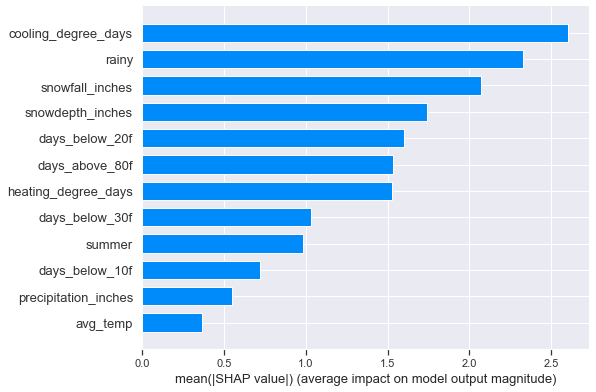

In [162]:
shap.summary_plot(shap_values, sample_set, plot_type="bar")

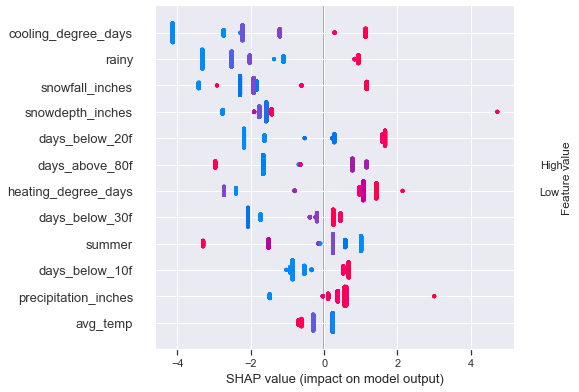

In [163]:
shap.summary_plot(shap_values, sample_set)

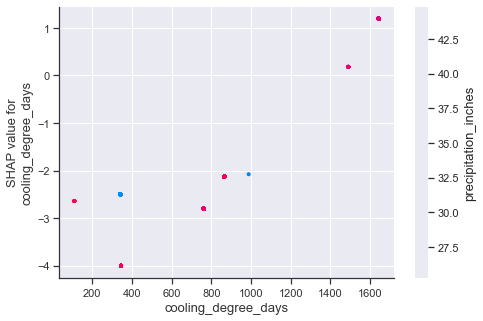

In [371]:
shap.dependence_plot('cooling_degree_days', shap_values, sample_set)

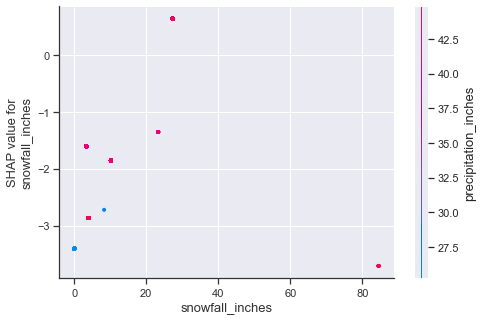

In [372]:
shap.dependence_plot('snowfall_inches', shap_values, sample_set)

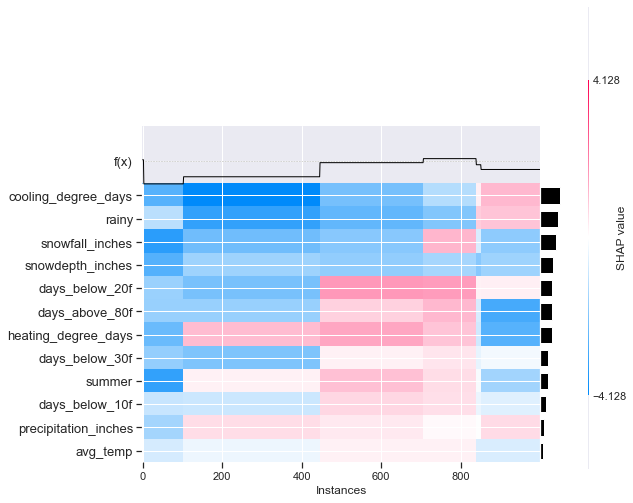

In [175]:
limit = 1000
shap.plots.heatmap(explainer(sample_set[:limit]), max_display=15)

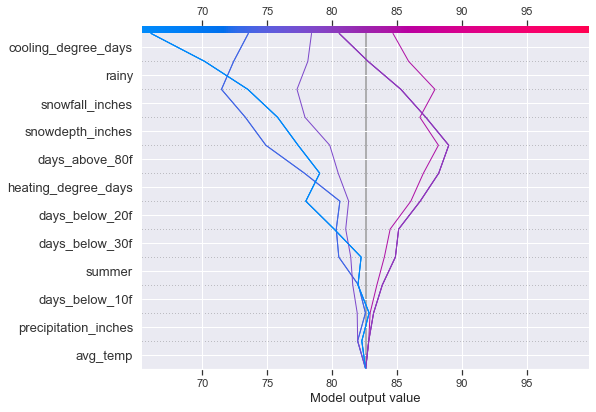

In [182]:
start = 150
limit = 160

shap.decision_plot(explainer.expected_value, shap_values[start:limit], feature_names=sample_set.columns.tolist())